<a href="https://colab.research.google.com/github/tdewaard/8dm40-machine-learning-GROUP6/blob/master/practicals/gan_practical_week5_group6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data synthesis using generative adversarial networks (GANs)

In this practical session we will build and train generative adversarial networks that are able to generate images.

This is a Google Colab notebook, which is mostly the same as a Jupyter notebook. This means that you can run the code in a cell by selecting the cell and pressing Shift+Enter. We will run everything in the cloud, so you don't need a fancy computer or an expensive GPU for this exercise. We are going to use GPUs that Google Cloud provides for free. To do this, go to Edit --> Notebook settings and select GPU as Hardware accelerator. Then, in the top right of this screen select 'CONNECT' --> 'Connect to hosted runtime'

We are going to import some of the packages that we will need in this exercise (by running the cell below)

The documentation for key packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For Keras: https://keras.io/ <br>
For random: https://docs.python.org/2/library/random.html <br> \\


In [0]:
import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from matplotlib import pylab
from IPython import display

import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_first')

import time
import random
from google.colab import files
from google.colab import widgets
random.seed(0)

# Check whether we're using a GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Found GPU at: /device:GPU:0


## Small steps
Before moving on to generating images, we will start with a simple 1D problem. We will assume that there is a data set of real samples that are drawn from a normal distribution with a particular mean value (the black dotted line below). These samples are in the sample domain *x*. 

The generator network does not know anything about the distribution of the real samples in the sample domain *x*, but will try to come up with a transformation that maps random noise from a distribution *z* to samples that seem to come from the real sample distribution (the green line below). This is very similar to what we have looked at in the lecture.

<img src="https://cs.stanford.edu/people/karpathy/gan/gan.png">

For this, we will define two neural networks that play a game:
*   The discriminator will learn to distinguish real and fake samples in *z*
*   The generator will generate fake samples in *z* that the discriminator cannot discriminate

First, we determine the mean value of the normal distribution from which **real** samples will be drawn in the sample domain *x*. In addition, we define the dimensionality of the normal distribution *z* from which noise samples to the generator will be drawn, i.e. the latent space. This will be 1 for now.

In [0]:
real_mean = 8
latent_dim = 1

Next, we define our discriminator and generator. These are both very simple networks.

**Question** How many layers does each of these networks have? \\
**Answer** Leaky ReLU is an activation function of layer 1, hence both networks have 2 layers.

**Question** Can you find out how many trainable parameters the networks have? \\
**Answer** Both networks have 97 trainable parameters (by looking at generator.summary() and discriminator.summary())

**Question** What are the activation functions of both networks? Why are they like this? \\
**Answer** The activation functions are LeakyReLu for the first dense layer and sigmoid for the last layer. \\
The LeakyReLu's help the gradients to flow easier through the network. The only way the generator has to learn is by receiving gradients from the discriminator. When using a 'normal' ReLU all outputs could be 0s (known as the dying ReLU problem) and then the gradients are completely shut to flow through the network. Therefore especially in GANs LeakyReLu might be a good choice. \\
The sigmoid at the end is used because probabilities have to be the output. 

In [0]:
# For easier reading
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU

# The discriminator will directly classify the input value
def get_discriminator_1D():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(32, input_dim=1))
  discriminator.add(LeakyReLU())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

# The generator will transform a single input value
def get_generator_1D():
  generator = keras.models.Sequential()
  generator.add(Dense(32, input_dim=1))
  generator.add(LeakyReLU())
  generator.add(Dense(1))
  return generator

discriminator = get_discriminator_1D();
discriminator.summary()

generator = get_generator_1D()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
____________________________________

Now, we will define the training functions for both networks. Consider what is actually happening in a GAN and how the inputs and outputs are connected. There are three variables when training this GAN

*   **z**: the noise that will be input to the generator
*   **G_z**: the output of the generator, i.e. the samples that should approximate the real samples
*   **D_G_z**: the discriminator's decision based on the fake sample

The overall objective function of our system is as follows

$V^{(D)}(D,G)=\underset{x\sim p_{data}}{\mathbb{E}} [\log{D(x)}]+\underset{z\sim p_z}{\mathbb{E}} [\log{(1-D(G(z)))}]$

The generator $G$ is trying to minimize this loss, and the discriminator $D$ tries to maximize this. In other words, the discriminator wants to minimize the binary cross-entropy s.t. it predicts 1 for real samples and 0 for fake samples. At the same time, the generator tries to get the discriminator to predict 1 for fake samples.




In [0]:
# Get networks
discriminator = get_discriminator_1D()
generator = get_generator_1D()

# Configure both models for training
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

# To configure the full model, we will set the 'trainable' parameter of the discriminator to False, as we don't want to optimize the discriminator when optimizing the generator
discriminator.trainable = False

# The input variable (noise) for the generator
z = keras.layers.Input(shape=(latent_dim,))

# What comes out of the generator
G_z = generator(z)

# What comes out of the discriminator when classifying the 'fake' samples
D_G_z = discriminator(G_z)

# The full GAN model
gan = keras.models.Model(inputs=z, outputs=D_G_z)

# The loss function for the GAN: this gets lower if the fake samples are classified as real
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

The code below runs the training loop. This could take a while. The code will periodically show a plot of the current situation.

**Question** Why do we set discriminator.trainable to either True or False? \\
**Answer** First the discriminator is trained/updated (discriminator.trainable = True). To train/update the generator, you have to backpropagate through the entire combined model while freezing the weights of the discriminator you just updated (discriminator.trainable = False), such that only the generator is updated.  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

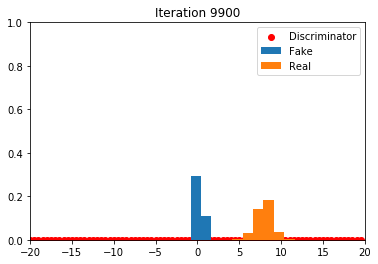

<IPython.core.display.Javascript object>

In [0]:
# We will store the losses here
g_losses = []
d_losses = []

# Training loop
n_samples = 100
epochs = 10000

grid = widgets.Grid(1, 1)

for e in range(epochs):
  # Get a random set of input noise
  # The normal distribution:
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # Uniform distribution:
  #noise = np.random.uniform(-1,1,size = [n_samples, latent_dim])

  # Also get a sample from the 'real' distribution
  #real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])

  # Trying different real distributions
  #real = np.random.laplace(real_mean, 1, size=[n_samples, latent_dim])
  #real = np.random.exponential(real_mean, size=[n_samples, latent_dim])
  #real = np.random.gumbel(real_mean, 1, size=[n_samples, latent_dim])
  #real = np.random.logistic(real_mean, 1, size=[n_samples, latent_dim])
  real = np.random.lognormal(real_mean, 1, size=[n_samples, latent_dim])

  
  # Generate some fake samples using the generator
  fake = generator.predict(noise)

  # Concatenate the fake and real images
  X = np.concatenate([real, fake])

  # Labels for generated and real data
  Y_dis = np.zeros(2*n_samples)
  
  # Set labels for real samples to 1
  Y_dis[:n_samples] = 1

  # Train discriminator with this batch of samples
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(X, Y_dis)
  d_losses.append(d_loss)
  
  # Train generator with a new batch of generated samples
  # Freeze the discriminator part
  discriminator.trainable = False 
  noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
  # From the generator's perspective, the discriminator should predict
  # ones for all samples
  Y_gen = np.ones(n_samples)
  g_loss = gan.train_on_batch(noise, Y_gen)
  g_losses.append(g_loss)
  
  if e % 100 == 0:
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    fake = generator.predict(noise)        
    real = np.random.normal(real_mean, 1, size=[n_samples, latent_dim])
    pred = discriminator.predict(np.arange(-20, 20, 0.5).reshape((80, 1)))
    with grid.output_to(0, 0):
      grid.clear_cell()
      
      # plt.clf()
      pylab.hist((np.squeeze(fake), np.squeeze(real)), density=True, stacked=True)
      pylab.scatter(np.arange(-20, 20, 0.5), pred, c='r')     
      pylab.xlim(-20, 20)
      pylab.ylim(0, 1)
      pylab.title('Iteration {}'.format(e))
      pylab.legend(['Discriminator', 'Fake', 'Real'])
    time.sleep(0.5)

If all is well, the fake and real distributions should nicely overlap after training. The discriminator has essentially pushed the fake samples towards the real distribution and the generator is now able to transform the noise distribution into a distribution of 'real' samples!

**Question** Can you explain what happened to the red line during training? Why does it look like it does after training? \\
**Answer** During training the red line first gives high values for the real data and low values for the fake data. As the fake data 'moves' more and more towards the real data, the value goes to 0.5 where the real and fake data overlap and goes to zero for the other values. After training the red line is a flat line at 0.5 (for the values of the fake and real distribution), which means that the discriminator is unable to differentiate between the two distributions. The generator is now able to transform the noise distribution into a distribution of 'real' samples. 

**Question** Try training the GAN with different input noise distributions, e.g. uniform. \\
**Answer** noise = np.random.uniform(-1,1,size = [n_samples, latent_dim])

**Question** See if you can find a distribution for the real samples for which the generator fails to generate samples. \\
**Answer** A variety of different distributions were implemented for the real samples. It was found that when using the lognormal distribution the generator is having a hard time generating samples from this distribution (when the fake samples are drawn from the normal distribution). The discriminator probabilities were found to very close to zero (even after 9900 epochs), indicating that generated samples are all classified as fake by the discriminator.  

During training, we have stored the loss values for the discriminator and the generator. We can now plot these. Remember that for the digit classification task, we were looking for a set of parameters leading to a low loss function. 

**Question** The loss curves that you get look different. Can you explain why they're not nicely dropping to zero? Can you explain the loss in the discriminator based on the objective function of the discriminator? \\
**Answer** The two losses should counterbalance one another. You need both a good generator and a good discriminator. The loss functions are "oscillating" with amplitudes in opposite directions, since when the discriminator is correctly classifying fake samples its loss function is small, while this is unwanted for the generator, so its loss would go up. As the generator is making fake samples that better represent the real samples, the oscillations in both loss functions slowly attentuate. When one of the two losses eventually goes to zero, no more learning would happen as the gradients vanish. If the generator is indeed making samples that represent the real distribution, an optimal trade-off value for the loss functions of generator and discriminator is now achieved. \\

No handles with labels found to put in legend.


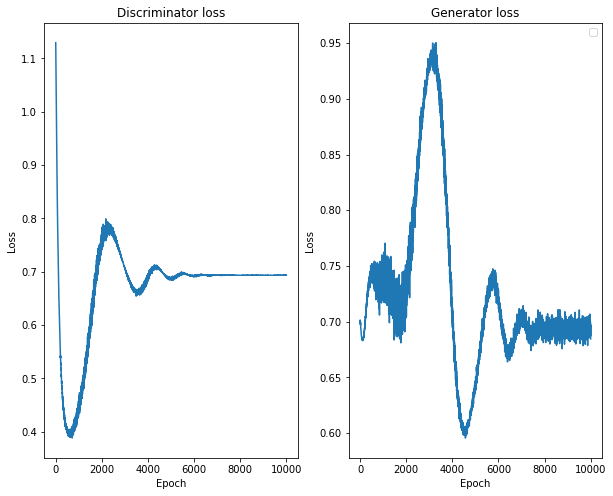

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Although it is definitely nice that we can train two networks together to learn the distribution of a real data distribution, generating samples from a normal distribution is in itself not really interesting. Luckily, we can use the same principles to generate images.

# MNIST synthesis
Like last week, we are again going to use MNIST data. Data preparation is the same as before.

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1)
test_set_images = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)
test_set_labels = to_categorical(y_test, num_classes=10)

11493376/11490434 [==============================] - 2s 0us/step


Plot some images.

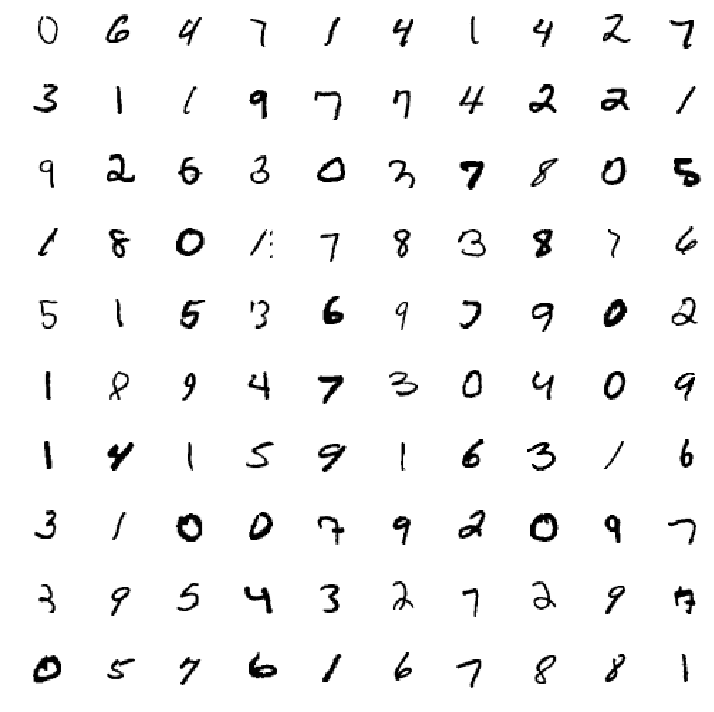

In [0]:
def plotImages(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plotImages(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28))

In last week's exercise you have built a discriminative model that was able to classify an image into one of ten digit categories. In this exercise, we are going to do the inverse. Given a point in a latent space (which in our case will be a multi-dimensional Gaussian distribution), we are going to train the network to generate a realistic digit image for this point. The MNIST data set will be used as a set of real samples. 

<img src="https://skymind.ai/images/wiki/GANs.png">



## The discriminator
As you can see in the image above, we will need a generator and a discriminator network. Let's define these. Consider the network that you used
for digit classification in the previous exercise and see if you can spot some differences between that network and the network below.

**Question** Is this a convolutional neural network? Why (not)? \\
**Answer** No, there are no convolutional layers, only fully connected layers (Dense). These are multilayer perceptrons, a class of feedforward neural networks. 

In [0]:
def get_discriminator_MLP():
  discriminator = keras.models.Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

You could argue that digits are a bit more complex than samples from a Gaussian distribution, so let's set the latent space dimensionality for noise sampling a bit higher than 1.

In [0]:
latent_dim = 10


## The generator

The generator is different than the discriminator. It should go from a low-dimensional noise vector to an MNIST image.

In [0]:
def get_generator_MLP():
  generator = keras.models.Sequential()
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  return generator

gen = get_generator_MLP()
dis = get_discriminator_MLP()
gen.summary()
dis.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_234 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_271 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_235 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_272 (Dense)            (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_236 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_273 (Dense)            (None, 784)             

**Question** Consider the activation functions of the output layers of the generator and discriminator networks. How are they different? \\
**Answer** Discriminator: sigmoid. Generator: tanh. The discriminator should output a probability between 0 and 1. The range of values of pixels is between [-1,1], therefore tanh is used for the generator which outputs values between [-1,1]. 

**Question** Also look at the activation functions of the other layers, can you find out what they do? Look at the Keras documentation. \\
**Answer** Leaky ReLU is used as activation functions. These allow a small positive gradient when the unit is not active (A normal ReLU would be zero for $x \leq 0$, Leaky ReLU has a small gradient e.g.: $0.01*x$ for $x \leq 0$). The LeakyReLu's help the gradients to flow easier through the network. The only way the generator has to learn is by receiving gradients from the discriminator. When using a 'normal' ReLU all outputs could be 0s (known as the dying ReLU problem) and then the gradients are completely shut to flow through the network. Therefore especially in GANs LeakyReLu might be a good choice.


## The model
Now  let's combine the generator and the discriminator. We train both using a binary crossentropy objective. This is very similar to what we did before.

In [0]:
discriminator = get_discriminator_MLP()
generator = get_generator_MLP()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
G_z = generator(z)
D_G_z = discriminator(G_z)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Some helper functions.

In [0]:
def saveModels(gen, dis, epoch, name):
    gen.save(name+'_generator_epoch_{}.h5'.format(epoch))
    dis.save(name+'_discriminator_epoch_{}.h5'.format(epoch))
    
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch {}'.format(epoch))
    plt.show()

Run the code below to train the GAN model. Synthesized images should be shown periodically. 

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 784).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):

    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # One-sided label smoothing
    y_dis[:batch_size] = 0.9

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

  # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    plotGeneratedImages(e)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    saveModels(e, name='gan')



<Figure size 432x288 with 0 Axes>

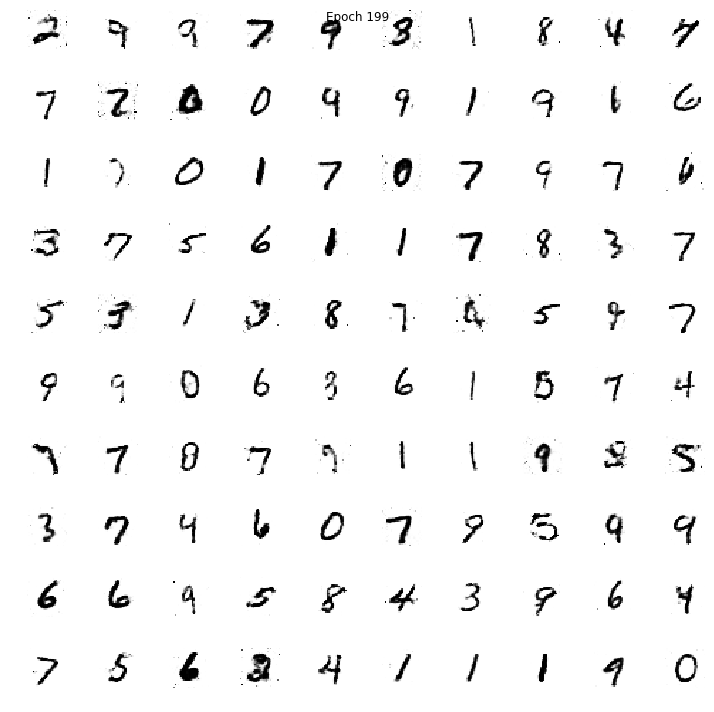

In [0]:
plotGeneratedImages(e)

**Question** Inspect the loss curves for this model and explain what happens. \\
**Answer** The discriminator loss is low in the beginning, meaning it can easily tell the difference between real and fake images. Slowly, the discriminator loss increases and the generator loss decreases as training progress, which implies that the discriminator tends to detect fake images as real / can't tell the difference between fake and real images anymore. So, after training the generator is making images that represent the real data quite well.

No handles with labels found to put in legend.


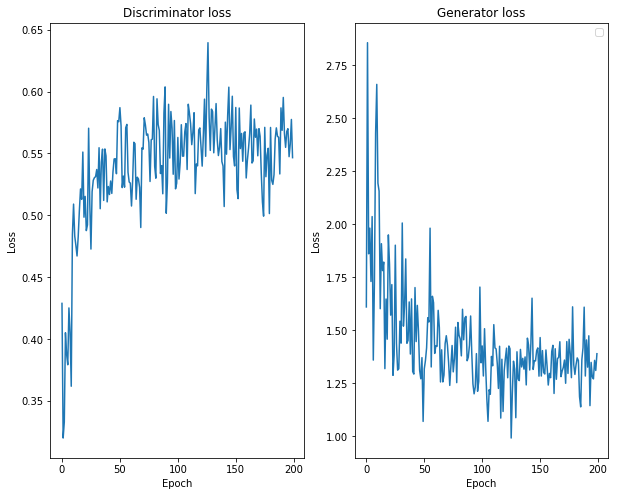

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(d_losses)
plt.title('Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(g_losses)
plt.title('Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## A convolutional model
Thus far the discriminator and generator were both multilayer perceptrons. Now we're going to add in some convolutional layers to turn them into a deep convolutional GAN (<a href="http://arxiv.org/abs/1511.06434">DCGAN</a>)-like architecture. This means that we have to redefine the generator network and a discriminator network. 

The discriminator network is (almost) the same network that we used in last week's exercise.

In [0]:
from keras.layers.convolutional import Conv2D, UpSampling2D

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

Let's build our model like before.

In [0]:
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

Train the model using the code below. Inspect the samples that come out. 

**Question** What are some differences between these samples and the ones generated by the multilayer perceptron GAN? Can you explain these differences? \\
**Answer** After a few epochs of training the convolutional model, it is already quite clear how less noise is present in the images compared to the multilayer perceptron model. After some more epochs, images from the convolutional model show much easier readable numbers with greater fidelity than the multilayer perceptron model.

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if e % 5 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(100, 28, 28)          
    plotImages(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    saveModels(e, name='conv_gan')

(128, 1, 28, 28)
(128, 1, 28, 28)
(128, 1, 28, 28)
(128, 1, 28, 28)
(128, 1, 28, 28)


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: ignored

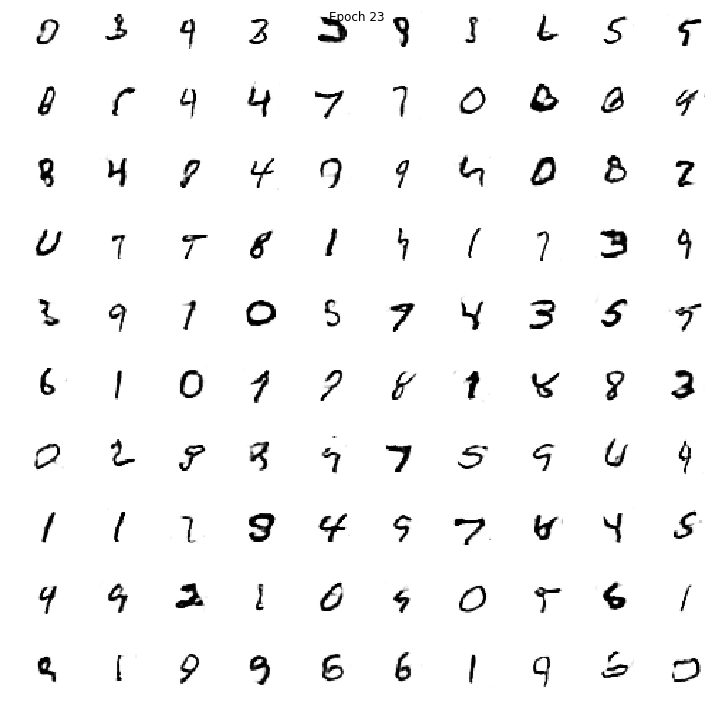

In [0]:
plotGeneratedImages(e)

## Interpolation in the latent space
We're going to explore the latent space a bit more. We pick two points in the latent space and make a linear interpolation between these two. Then we generate images from each of the interpolated latent points. 

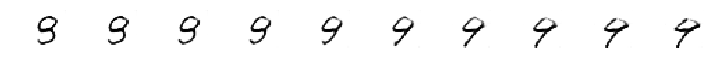

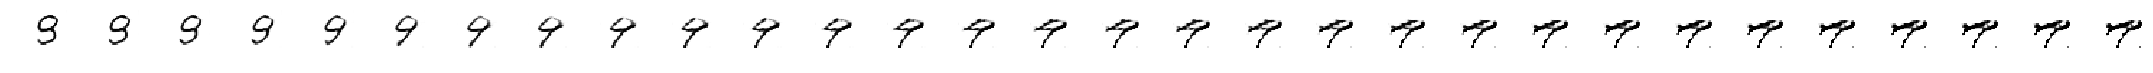

In [0]:
noise_a = np.random.normal(0, 1, size=[1, latent_dim])
noise_b = np.random.normal(0, 1, size=[1, latent_dim])

noise = np.zeros((10, latent_dim), dtype='float32')
for ni in range(10):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(10, 28, 28)          
plotImages(generatedImages, dim=(1, 10), figsize=(10, 10))

# Extrapolating the noise

noise = np.zeros((30, latent_dim), dtype='float32')
for ni in range(30):
  noise[ni, :] = float(ni)/10. * noise_a + (1 - float(ni)/10.) * noise_b
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(30, 28, 28)          
plotImages(generatedImages, dim=(1, 30), figsize=(30, 10))

**Question** Explain what you see in this plot. \\
**Answer** The images that the generator would generate from linearely interpolated points in latent space. The result is a series of images that transition between the two images that correspond to the two points in latent space we started with. You clearly see the shape slowly transform from one to another. For example transition from a 9 to a 3.  

**Question** What happens when you extrapolate out of the latent space distribution? Consider how the noise vectors are drawn. \\
**Answer** Extrapolating out of the latent space would correspond to taking "random" samples that are further away from the mean of the two normal distributions `noise_a` and `noise_b`. In the `for` loop above one can change `ni` to range up until $30$ for example. The generated noise is still dependent on the two distributions, but different fractions/multiples of `noise_a` and `noise_b` are taken. This should corresponds to output images that are not "in-between" two numbers, but should generate "new" numbers that show some characteristics with the real numbers from MNIST. In the code above is is seen how a 9 is transformed into a 4 during interpolation. When extrapolating the noise, the 4 is further transformed into something that does not resemble any number, although it starts to resemble a 7. The further away you go from latent space, the less the image will look like a number / like the real images. The image that will be generated will still look a bit like a number but very "degenerated".


# Histopathology image synthesis

Now we're going to synthesize some actual images. We're going to use the PatchCamelyon data set ([more info here](https://github.com/basveeling/pcam)) which consists of small images that can be used for classification benchmarks. Today, we're not going to classify images, but we're going to synthesize them. You can download a data set of smaller (28 x 28 pixels) versions of these images from 
[this link](https://filesender.surf.nl/?s=download&token=09f710b3-25f6-43f6-b554-5162390494e2). Upload the data set in the dialog below.

In [0]:
uploaded = files.upload()

Saving valid_28.pkl.gz to valid_28.pkl.gz


Now load the data set.

In [0]:
def loadPatchCamelyon(path):    
    f = gzip.open(path, 'rb')
    train_set = pickle.load(f, encoding='latin1')
    f.close()
    return train_set

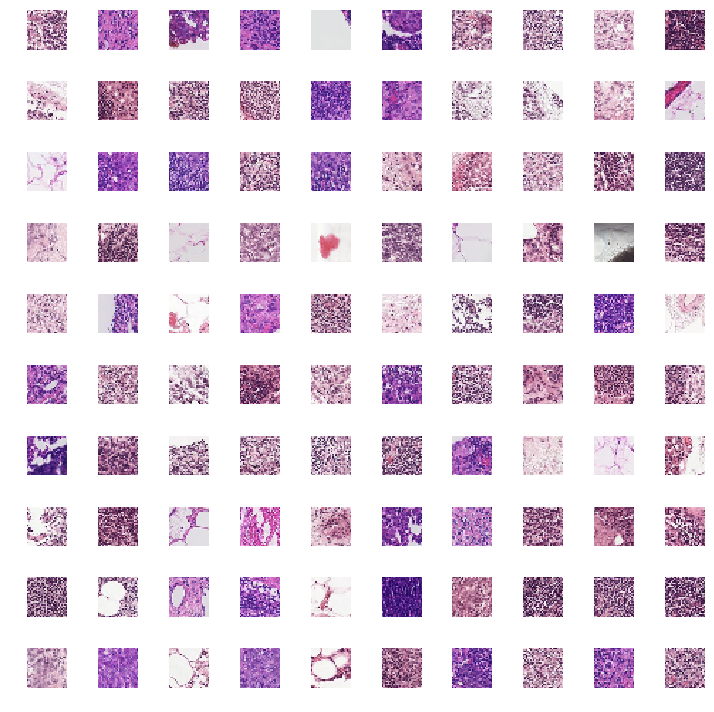

In [0]:
def plotImagesPatchCamelyon(images, dim=(10, 10), figsize=(10, 10), title=''):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
train_set_images = loadPatchCamelyon(r'valid_28.pkl.gz')    
plotImagesPatchCamelyon(train_set_images[np.random.randint(0, train_set_images.shape[0], size=100)].reshape(100, 28, 28, 3)/255.0)

What do you immediately notice? Indeed, these images are in color! So the generator will have to generate three output channels instead of just one. 

In this second-to-last part of the practical you're going to repurpose the code that you have used so far to synthesize histopathology images like the ones above. You can play around a bit with this, see what happens when you interpolate between samples, etc. Remember that there is a final 'exercise' below.

**Good luck!**

In [0]:
## YOUR CODE GOES HERE

from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU

def get_discriminator_CNN():
  discriminator = keras.models.Sequential()
  discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(3,28,28), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

def get_generator_CNN():
  generator = keras.models.Sequential()
  generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((128, 7, 7)))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D(size=(2, 2)))
  generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='tanh'))
  return generator

In [0]:
latent_dim = 10
generator = get_generator_CNN()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 64, 28, 28)       

In [0]:
latent_dim = 100;
discriminator = get_discriminator_CNN()
generator = get_generator_CNN()

discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

discriminator.trainable = False
z = keras.layers.Input(shape=(latent_dim,))
x = generator(z)
D_G_z = discriminator(x)
gan = keras.models.Model(inputs=z, outputs=D_G_z)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

In [0]:
d_losses = []
g_losses = []

epochs = 200
batch_size = 128

#normalize images to [-1,1]
X_train = (train_set_images.reshape(train_set_images.shape[0], 3, 28, 28).astype(np.float32) - 127.5)/127.5

batch_count = int(X_train.shape[0] / batch_size)
for e in range(epochs):
  for _ in range(batch_count):
    # Get a random set of input noise and images
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    generated_images = generator.predict(noise)

    # Concatenate the fake and real images
    X = np.concatenate([image_batch, generated_images])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Train generator with a new batch of generated samples
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    discriminator.trainable = False

    # Train the GAN to predict ones
    g_loss = gan.train_on_batch(noise, y_gen)

    # Store loss of most recent batch from this epoch
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  if e % 10 == 0:
    noise = np.random.normal(0, 1, size=[100, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = (generatedImages.reshape(100, 28, 28, 3) + 1 ) / 2.0       
    plotImagesPatchCamelyon(generatedImages, title='Epoch {}'.format(e))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)    
    #saveModels(e)

<Figure size 432x288 with 0 Axes>

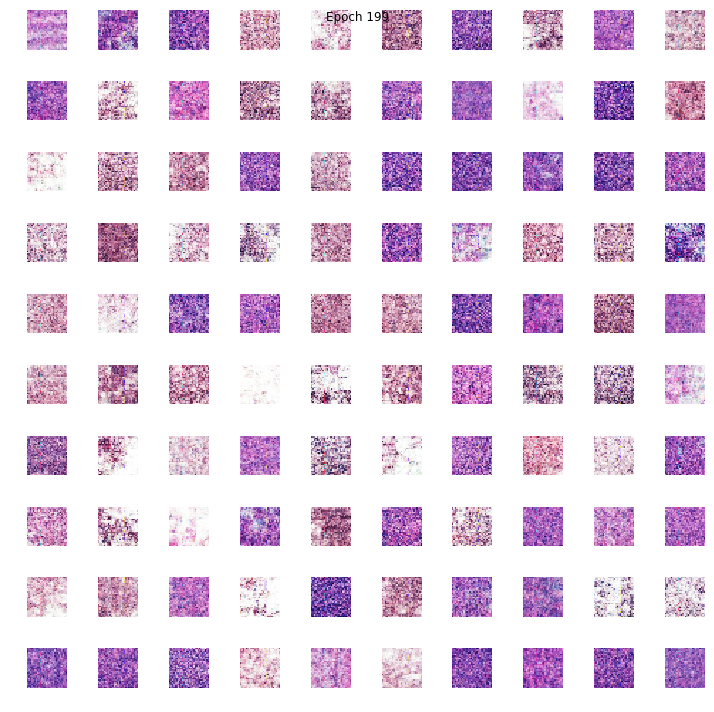

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
noise = np.random.normal(0, 1, size=[100, latent_dim])
generatedImages = generator.predict(noise)
generatedImages = (generatedImages.reshape(100, 28, 28, 3) + 1 ) / 2.0       
plotImagesPatchCamelyon(generatedImages, title='Epoch {}'.format(e))
display.display(plt.gcf())

# Conditional image synthesis

## The BigGAN model
The images we have synthesized so far are all quite small. Synthesis of larger images (e.g. 512 x 512 pixels) typically requires a lot of compute power and patience. Unfortunately, you don't have 100s of GPU at your disposal (I guess) to train a model like BigGAN, the state of the art in conditional image synthesis. A wild guess is that it would cost you around [USD60000](https://twitter.com/quasimondo/status/1065610256917692416) to train this model.

Luckily, the authors of BigGAN have put a version of their pretrained model online and you can use it to synthesize images. Go to [this Colaboratory file](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb) and answer the following questions.

**Question** What happens when you change the noise seed? Also try out different categories. \\

**Answer** Different random noise is used as input for the genertor, resulting in slightly different generated images within the same category. Looking at pretzels for example, different pretzel shapes are shown (among some other minor variations) when the noise seed is varied. 

**Question** What happens to your samples when you change the truncation value? More precisely, what happens to the diversity and the quality of your samples? Take a look at the [paper on arXiv](https://arxiv.org/abs/1809.11096) Sec. 3.1 to get an idea what this value does. \\

**Answer** Reducing the truncation value gives many images with higher fidelity (e.g. all images are easily distinguished as real pretzels). Also, generated images look much more similar. Increasing the truncation value decreases the fidelity (e.g. some images show "pretzels" that look very deviating from real pretzels). The generated images do however look less similar now, i.e. there is more variation between the images. This can be explained as smaller truncation values truncate the normal distribution of the input noise more (by resampling until samples are within a certain range). This gives more similar samples from the latent space corresponding to less variation and increased fidelity in the generated images. \\

**Question** Interpolate between image categories, inspect what these look like. \\

**Answer** Interpolating between categories shows images that gradually change to a different category. E.g. interpolating between a dog and a vulture shows the dog gradually morphing into a vulture in the generated images.



## Conditional MNIST synthesis
For all MNIST samples we already have labels (0, 1, ..., n). Try to change the MNIST synthesis code such that you can ask the generator to generate specific labels. I.e., try to train a conditional GAN. You can look for some inspiration in [this paper](https://arxiv.org/pdf/1411.1784.pdf), in particular Sec. 4.1. Remember that you already got the MNIST labels when loading the data set.

In [0]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, \
                         Conv2D, Conv2DTranspose, Reshape, Dropout, \
                         Activation, LeakyReLU, BatchNormalization, \
                         Flatten
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

def get_generator_cond(latent_dim, num_labels):

  # z = Dense(200)(inputs)
  # z = Activation(LeakyReLU(0.2))(z)
  # y = Dense(1000)(labels)
  # y = Activation(LeakyReLU(0.2))(y)
  # x = concatenate([z, y])
  # x = Dense(1200)(x)
  # x = Activation(LeakyReLU(0.2))(x)
  # x = Dense(784, activation='tanh')(x)
  # x = Reshape((1, image_size, image_size))(x)
  inputs = Input(shape=(latent_dim,), name='noise')
  labels = Input(shape=(n_labels,), name='gen_labels')

  kernel_size = 5
  layer_filters = [128, 64, 32, 1]

  x = concatenate([inputs, labels], axis=1)
  x = Dense(7 * 7 * layer_filters[0])(x)
  x = Reshape((7, 7, layer_filters[0]))(x)

  for filters in layer_filters:
      if filters > layer_filters[-2]:
          strides = 2
      else:
          strides = 1
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = Conv2DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding='same',
                          data_format='channels_last')(x)

  x = Activation('sigmoid')(x)

  model = Model([inputs, labels], x, name='generator')
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0002, beta_1 = 0.5),
                metrics=['accuracy'])
  return model


def get_discriminator_cond(num_labels, image_size):

  # x = Reshape((image_size**2,))(inputs)
  # x = Dense(240*5)(x)
  # x = Activation(LeakyReLU(0.2))(x)
  # y = Dense(50*5)(labels)
  # y = Activation(LeakyReLU(0.2))(y)
  # x = concatenate([x, y])
  # x = Dense(240*4)(x)
  # x = Activation(LeakyReLU(0.2))(x)
  # #x = Dropout(0.5)(x)
  # x = Dense(1, activation='sigmoid')(x)
  labels = Input(shape=(num_labels,), name='labels')
  inputs = Input(shape=(image_size,image_size, 1), name='discriminator_images') 

  kernel_size = 5
  layer_filters = [32, 64, 128, 256]

  x = inputs
  y = Dense(image_size * image_size)(labels)
  y = Reshape((image_size, image_size, 1))(y)
  x = concatenate([x, y], axis=1)

  for filters in layer_filters:
      if filters == layer_filters[-1]:
          strides = 1
      else:
          strides = 2
      x = LeakyReLU(alpha=0.2)(x)
      x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  data_format='channels_last')(x)

  x = Flatten()(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model([inputs, labels], x, name='discriminator')
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0002, beta_1 = 0.5),
                metrics=['accuracy'])
  return model

def get_gan(dis, gen, latent_dim, num_labels):

  noise = Input(shape=(latent_dim, ), name='gan_noise')
  labels = Input(shape=(num_labels,), name='gan_labels')
  
  w = [gen([noise, labels]), labels]
  print(w[0].shape)
  dis.trainable = False
  outputs = dis(w)

  model = Model([noise, labels],
               outputs,
               name='cgan')
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0002, beta_1 = 0.5),
                metrics=['accuracy'])
  return model


# load the MNIST the dataset
(x_train, y_train), (_,_) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)

# convert the data to channel-last
train_set_images = np.expand_dims(x_train, axis=-1) 

# convert the labels to one-hot encoded
train_set_labels = to_categorical(y_train, num_classes=10)

latent_dim = 100
n_labels = train_set_labels.shape[1]

z_shape = (latent_dim,)
label_shape = (n_labels,)
image_shape = train_set_images.shape[1:]

# generator
gen = get_generator_cond(latent_dim, n_labels)
gen.summary()

# discriminator
dis = get_discriminator_cond(n_labels, image_shape[0])
dis.summary()

# gan
gan = get_gan(dis, gen, latent_dim, n_labels)
gan.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
gen_labels (InputLayer)         (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 110)          0           noise[0][0]                      
                                                                 gen_labels[0][0]                 
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 6272)         696192      concatenate_3[0][0]      

========== Epoch 0 ==========

CGAN loss = 0.8640000224113464	 Discr. loss = 0.5320000052452087
Images should show 3


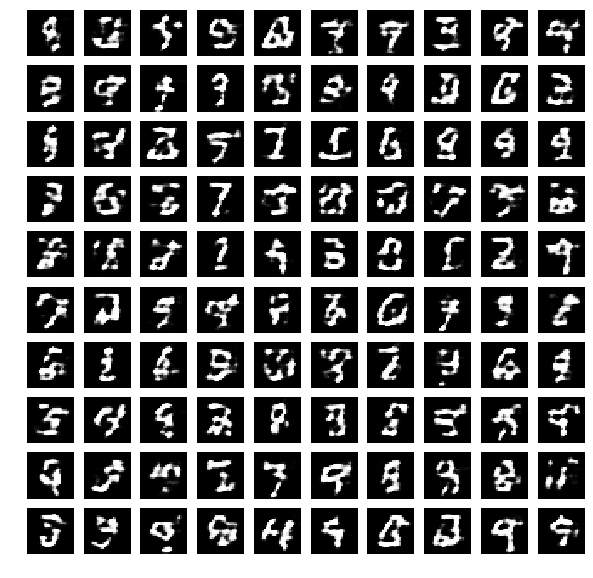

========== Epoch 1 ==========

CGAN loss = 1.1640000343322754	 Discr. loss = 0.6949999928474426
========== Epoch 2 ==========

CGAN loss = 0.902999997138977	 Discr. loss = 0.6420000195503235
========== Epoch 3 ==========

CGAN loss = 0.9940000176429749	 Discr. loss = 0.6520000100135803
========== Epoch 4 ==========

CGAN loss = 0.972000002861023	 Discr. loss = 0.6650000214576721
========== Epoch 5 ==========

CGAN loss = 0.7630000114440918	 Discr. loss = 0.6520000100135803
========== Epoch 6 ==========

CGAN loss = 0.8299999833106995	 Discr. loss = 0.6949999928474426
========== Epoch 7 ==========

CGAN loss = 0.7699999809265137	 Discr. loss = 0.6460000276565552
========== Epoch 8 ==========

CGAN loss = 0.996999979019165	 Discr. loss = 0.6079999804496765
========== Epoch 9 ==========

CGAN loss = 0.8159999847412109	 Discr. loss = 0.6570000052452087
========== Epoch 10 ==========

CGAN loss = 0.734000027179718	 Discr. loss = 0.656000018119812
Images should show 0


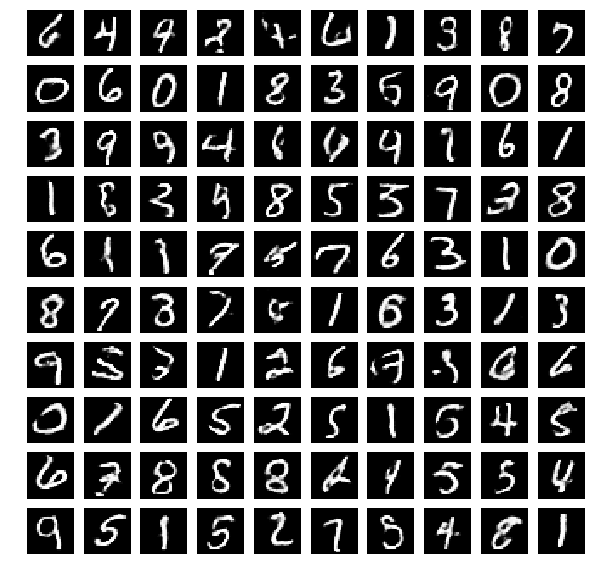

========== Epoch 11 ==========

CGAN loss = 0.7850000262260437	 Discr. loss = 0.675000011920929
========== Epoch 12 ==========

CGAN loss = 0.7419999837875366	 Discr. loss = 0.6309999823570251
========== Epoch 13 ==========

CGAN loss = 0.949999988079071	 Discr. loss = 0.6650000214576721
========== Epoch 14 ==========

CGAN loss = 0.8420000076293945	 Discr. loss = 0.6209999918937683
========== Epoch 15 ==========

CGAN loss = 0.6840000152587891	 Discr. loss = 0.6650000214576721
========== Epoch 16 ==========

CGAN loss = 0.8330000042915344	 Discr. loss = 0.6330000162124634
========== Epoch 17 ==========

CGAN loss = 0.8619999885559082	 Discr. loss = 0.6230000257492065
========== Epoch 18 ==========

CGAN loss = 0.9129999876022339	 Discr. loss = 0.6669999957084656
========== Epoch 19 ==========

CGAN loss = 1.0520000457763672	 Discr. loss = 0.6489999890327454
========== Epoch 20 ==========

CGAN loss = 0.8370000123977661	 Discr. loss = 0.656000018119812
Images should show 3


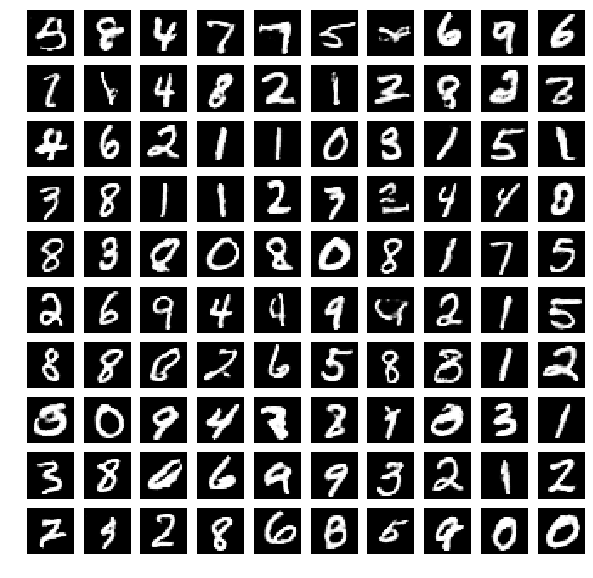

========== Epoch 21 ==========

CGAN loss = 0.6949999928474426	 Discr. loss = 0.6299999952316284
========== Epoch 22 ==========

CGAN loss = 0.8209999799728394	 Discr. loss = 0.6700000166893005
========== Epoch 23 ==========

CGAN loss = 0.6909999847412109	 Discr. loss = 0.6230000257492065
========== Epoch 24 ==========

CGAN loss = 0.7400000095367432	 Discr. loss = 0.6460000276565552
========== Epoch 25 ==========

CGAN loss = 0.7760000228881836	 Discr. loss = 0.640999972820282
========== Epoch 26 ==========

CGAN loss = 0.7139999866485596	 Discr. loss = 0.6499999761581421
========== Epoch 27 ==========

CGAN loss = 0.800000011920929	 Discr. loss = 0.652999997138977
========== Epoch 28 ==========

CGAN loss = 0.8830000162124634	 Discr. loss = 0.6629999876022339
========== Epoch 29 ==========

CGAN loss = 0.7630000114440918	 Discr. loss = 0.6389999985694885
========== Epoch 30 ==========

CGAN loss = 0.9769999980926514	 Discr. loss = 0.6700000166893005
Images should show 3


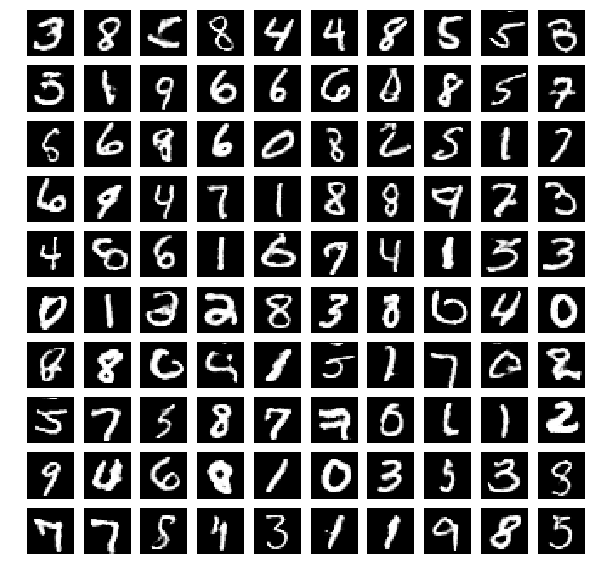

========== Epoch 31 ==========

CGAN loss = 1.0089999437332153	 Discr. loss = 0.6380000114440918
========== Epoch 32 ==========

CGAN loss = 0.6299999952316284	 Discr. loss = 0.6600000262260437
========== Epoch 33 ==========

CGAN loss = 0.7239999771118164	 Discr. loss = 0.6570000052452087
========== Epoch 34 ==========

CGAN loss = 0.8199999928474426	 Discr. loss = 0.6510000228881836
========== Epoch 35 ==========

CGAN loss = 0.8149999976158142	 Discr. loss = 0.6449999809265137
========== Epoch 36 ==========

CGAN loss = 1.0099999904632568	 Discr. loss = 0.6740000247955322
========== Epoch 37 ==========

CGAN loss = 0.7630000114440918	 Discr. loss = 0.6669999957084656
========== Epoch 38 ==========

CGAN loss = 0.8009999990463257	 Discr. loss = 0.6480000019073486
========== Epoch 39 ==========

CGAN loss = 0.8460000157356262	 Discr. loss = 0.6230000257492065
========== Epoch 40 ==========

CGAN loss = 0.7459999918937683	 Discr. loss = 0.625
Images should show 2


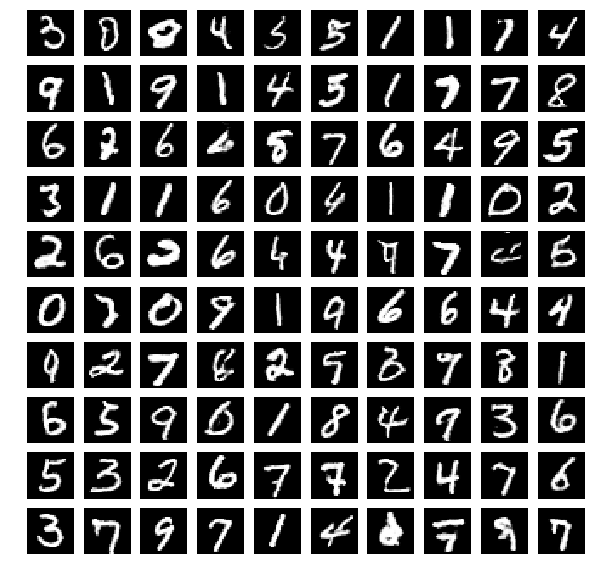

========== Epoch 41 ==========

CGAN loss = 0.7179999947547913	 Discr. loss = 0.6579999923706055
========== Epoch 42 ==========

CGAN loss = 0.7919999957084656	 Discr. loss = 0.6449999809265137
========== Epoch 43 ==========

CGAN loss = 0.9330000281333923	 Discr. loss = 0.6010000109672546
========== Epoch 44 ==========

CGAN loss = 0.9419999718666077	 Discr. loss = 0.6389999985694885
========== Epoch 45 ==========

CGAN loss = 0.7720000147819519	 Discr. loss = 0.6359999775886536
========== Epoch 46 ==========

CGAN loss = 0.8960000276565552	 Discr. loss = 0.6140000224113464
========== Epoch 47 ==========

CGAN loss = 0.9559999704360962	 Discr. loss = 0.6200000047683716
========== Epoch 48 ==========

CGAN loss = 1.0269999504089355	 Discr. loss = 0.6330000162124634
========== Epoch 49 ==========

CGAN loss = 0.9330000281333923	 Discr. loss = 0.5989999771118164
========== Epoch 50 ==========

CGAN loss = 1.0360000133514404	 Discr. loss = 0.625
Images should show 5


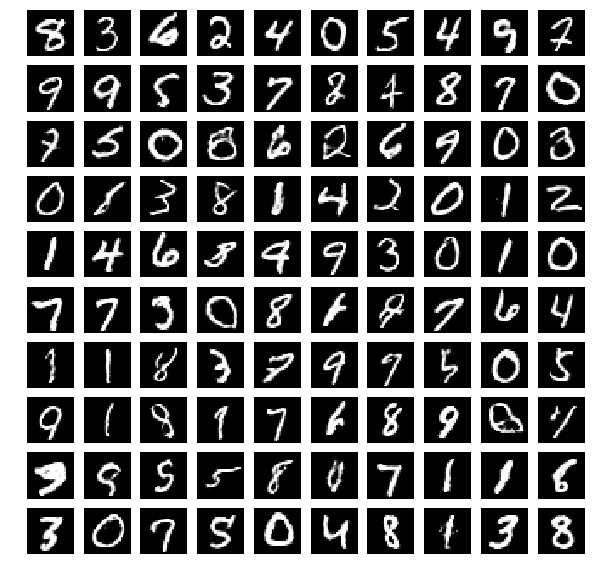

========== Epoch 51 ==========

CGAN loss = 0.8970000147819519	 Discr. loss = 0.6019999980926514
========== Epoch 52 ==========

CGAN loss = 0.8259999752044678	 Discr. loss = 0.6069999933242798
========== Epoch 53 ==========

CGAN loss = 0.9300000071525574	 Discr. loss = 0.6159999966621399
========== Epoch 54 ==========

CGAN loss = 1.0859999656677246	 Discr. loss = 0.6069999933242798
========== Epoch 55 ==========

CGAN loss = 0.9789999723434448	 Discr. loss = 0.652999997138977
========== Epoch 56 ==========

CGAN loss = 1.0010000467300415	 Discr. loss = 0.6159999966621399
========== Epoch 57 ==========

CGAN loss = 0.7860000133514404	 Discr. loss = 0.5730000138282776
========== Epoch 58 ==========

CGAN loss = 0.7919999957084656	 Discr. loss = 0.6159999966621399
========== Epoch 59 ==========

CGAN loss = 0.9409999847412109	 Discr. loss = 0.5950000286102295
========== Epoch 60 ==========

CGAN loss = 1.2000000476837158	 Discr. loss = 0.5789999961853027
Images should show 2


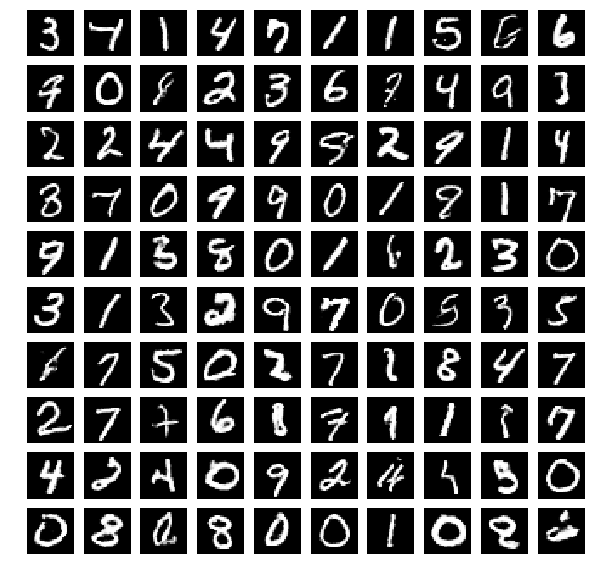

========== Epoch 61 ==========

CGAN loss = 1.0390000343322754	 Discr. loss = 0.609000027179718
========== Epoch 62 ==========

CGAN loss = 1.0499999523162842	 Discr. loss = 0.6290000081062317
========== Epoch 63 ==========

CGAN loss = 0.8420000076293945	 Discr. loss = 0.5979999899864197
========== Epoch 64 ==========

CGAN loss = 1.1390000581741333	 Discr. loss = 0.5960000157356262
========== Epoch 65 ==========

CGAN loss = 1.2209999561309814	 Discr. loss = 0.5830000042915344
========== Epoch 66 ==========

CGAN loss = 1.1759999990463257	 Discr. loss = 0.5960000157356262
========== Epoch 67 ==========

CGAN loss = 1.024999976158142	 Discr. loss = 0.5609999895095825
========== Epoch 68 ==========

CGAN loss = 1.1610000133514404	 Discr. loss = 0.5580000281333923
========== Epoch 69 ==========

CGAN loss = 1.1449999809265137	 Discr. loss = 0.6039999723434448
========== Epoch 70 ==========

CGAN loss = 0.9900000095367432	 Discr. loss = 0.5410000085830688
Images should show 0


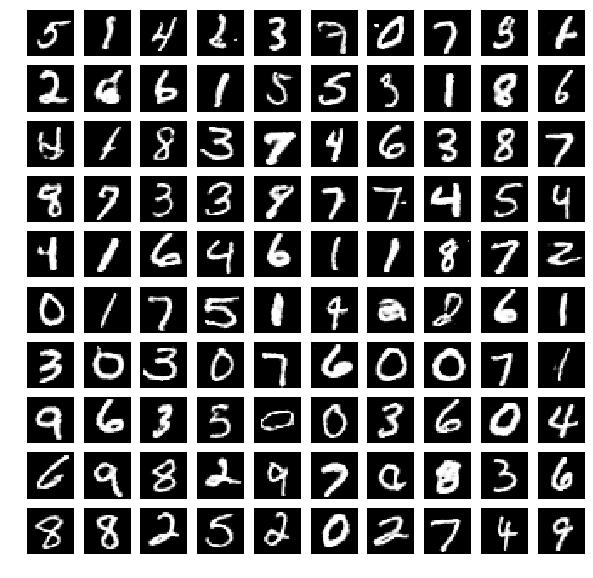

========== Epoch 71 ==========

CGAN loss = 1.121999979019165	 Discr. loss = 0.6179999709129333
========== Epoch 72 ==========

CGAN loss = 0.972000002861023	 Discr. loss = 0.5889999866485596
========== Epoch 73 ==========

CGAN loss = 1.1749999523162842	 Discr. loss = 0.5910000205039978
========== Epoch 74 ==========

CGAN loss = 1.1480000019073486	 Discr. loss = 0.5600000023841858
========== Epoch 75 ==========

CGAN loss = 1.1160000562667847	 Discr. loss = 0.5860000252723694
========== Epoch 76 ==========

CGAN loss = 1.1959999799728394	 Discr. loss = 0.5799999833106995
========== Epoch 77 ==========

CGAN loss = 1.0980000495910645	 Discr. loss = 0.5600000023841858
========== Epoch 78 ==========

CGAN loss = 1.2170000076293945	 Discr. loss = 0.6159999966621399
========== Epoch 79 ==========

CGAN loss = 1.2890000343322754	 Discr. loss = 0.5910000205039978
========== Epoch 80 ==========

CGAN loss = 1.1100000143051147	 Discr. loss = 0.5450000166893005
Images should show 6


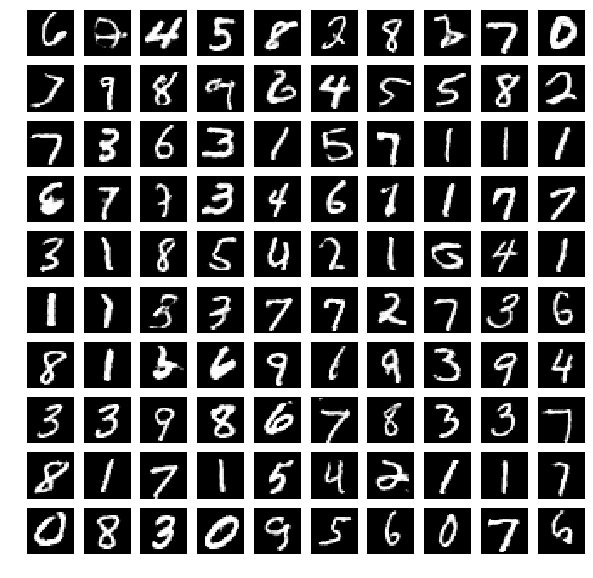

========== Epoch 81 ==========

CGAN loss = 1.2039999961853027	 Discr. loss = 0.5920000076293945
========== Epoch 82 ==========

CGAN loss = 1.069000005722046	 Discr. loss = 0.5770000219345093
========== Epoch 83 ==========

CGAN loss = 1.2630000114440918	 Discr. loss = 0.5360000133514404
========== Epoch 84 ==========

CGAN loss = 1.4249999523162842	 Discr. loss = 0.574999988079071
========== Epoch 85 ==========

CGAN loss = 0.9549999833106995	 Discr. loss = 0.5490000247955322
========== Epoch 86 ==========

CGAN loss = 1.2289999723434448	 Discr. loss = 0.546999990940094
========== Epoch 87 ==========

CGAN loss = 0.9409999847412109	 Discr. loss = 0.5400000214576721
========== Epoch 88 ==========

CGAN loss = 1.2359999418258667	 Discr. loss = 0.5870000123977661
========== Epoch 89 ==========

CGAN loss = 1.2269999980926514	 Discr. loss = 0.5649999976158142
========== Epoch 90 ==========

CGAN loss = 1.2330000400543213	 Discr. loss = 0.49000000953674316
Images should show 1


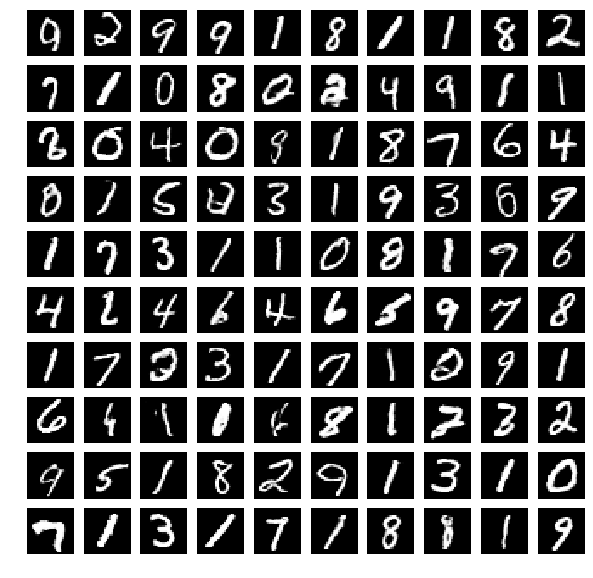

========== Epoch 91 ==========

CGAN loss = 1.2070000171661377	 Discr. loss = 0.5759999752044678
========== Epoch 92 ==========

CGAN loss = 0.9869999885559082	 Discr. loss = 0.5419999957084656
========== Epoch 93 ==========

CGAN loss = 1.1460000276565552	 Discr. loss = 0.5759999752044678
========== Epoch 94 ==========

CGAN loss = 1.2690000534057617	 Discr. loss = 0.5509999990463257
========== Epoch 95 ==========

CGAN loss = 1.3869999647140503	 Discr. loss = 0.5389999747276306
========== Epoch 96 ==========

CGAN loss = 1.2510000467300415	 Discr. loss = 0.5109999775886536
========== Epoch 97 ==========

CGAN loss = 1.069000005722046	 Discr. loss = 0.5320000052452087
========== Epoch 98 ==========

CGAN loss = 1.2769999504089355	 Discr. loss = 0.5149999856948853
========== Epoch 99 ==========

CGAN loss = 1.3980000019073486	 Discr. loss = 0.5529999732971191
========== Epoch 100 ==========

CGAN loss = 1.3170000314712524	 Discr. loss = 0.46700000762939453
Images should show 3


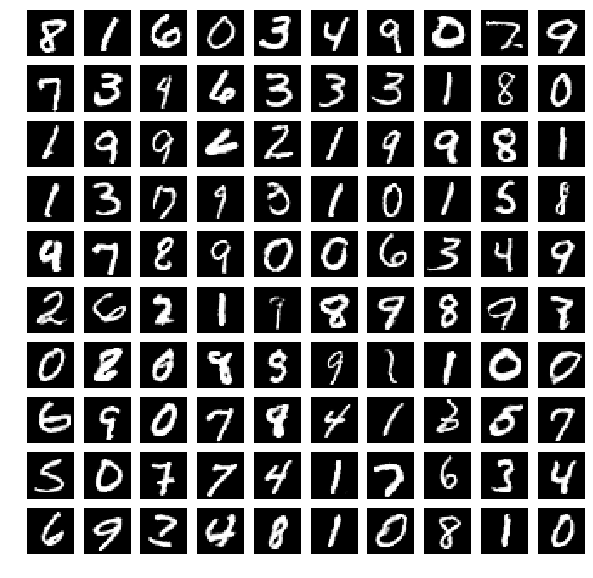

========== Epoch 101 ==========

CGAN loss = 1.3109999895095825	 Discr. loss = 0.5429999828338623
========== Epoch 102 ==========

CGAN loss = 1.3170000314712524	 Discr. loss = 0.5320000052452087
========== Epoch 103 ==========

CGAN loss = 1.4800000190734863	 Discr. loss = 0.49799999594688416
========== Epoch 104 ==========

CGAN loss = 1.2120000123977661	 Discr. loss = 0.5070000290870667
========== Epoch 105 ==========

CGAN loss = 1.3730000257492065	 Discr. loss = 0.5370000004768372
========== Epoch 106 ==========

CGAN loss = 1.3350000381469727	 Discr. loss = 0.5049999952316284
========== Epoch 107 ==========

CGAN loss = 1.309999942779541	 Discr. loss = 0.42899999022483826
========== Epoch 108 ==========

CGAN loss = 1.4709999561309814	 Discr. loss = 0.5080000162124634
========== Epoch 109 ==========

CGAN loss = 1.2999999523162842	 Discr. loss = 0.4950000047683716
========== Epoch 110 ==========

CGAN loss = 1.25600004196167	 Discr. loss = 0.49900001287460327
Images should show 2

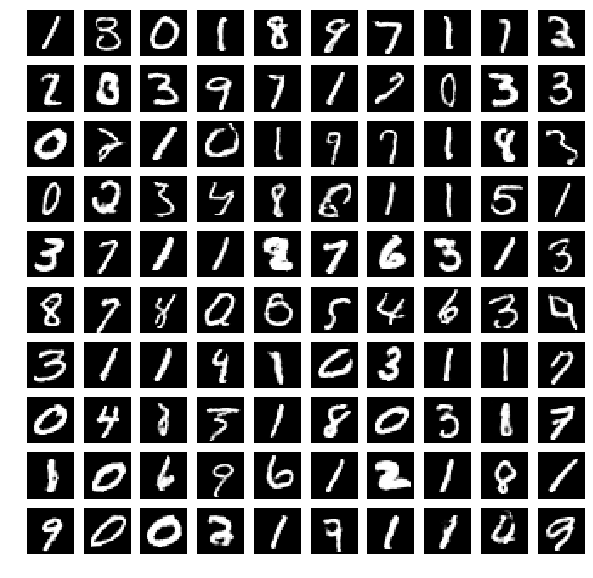

========== Epoch 111 ==========

CGAN loss = 1.3420000076293945	 Discr. loss = 0.5299999713897705
========== Epoch 112 ==========

CGAN loss = 1.284000039100647	 Discr. loss = 0.5220000147819519
========== Epoch 113 ==========

CGAN loss = 1.3009999990463257	 Discr. loss = 0.550000011920929
========== Epoch 114 ==========

CGAN loss = 1.434000015258789	 Discr. loss = 0.45899999141693115
========== Epoch 115 ==========

CGAN loss = 1.5609999895095825	 Discr. loss = 0.5130000114440918
========== Epoch 116 ==========

CGAN loss = 1.7120000123977661	 Discr. loss = 0.527999997138977
========== Epoch 117 ==========

CGAN loss = 1.3630000352859497	 Discr. loss = 0.531000018119812
========== Epoch 118 ==========

CGAN loss = 1.5049999952316284	 Discr. loss = 0.5419999957084656
========== Epoch 119 ==========

CGAN loss = 1.0950000286102295	 Discr. loss = 0.4189999997615814
========== Epoch 120 ==========

CGAN loss = 1.2940000295639038	 Discr. loss = 0.5180000066757202
Images should show 0


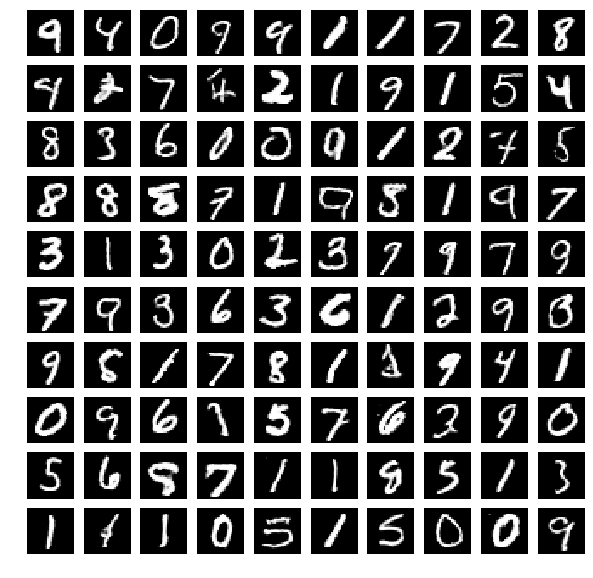

========== Epoch 121 ==========

CGAN loss = 1.5829999446868896	 Discr. loss = 0.5410000085830688
========== Epoch 122 ==========

CGAN loss = 1.809999942779541	 Discr. loss = 0.5389999747276306
========== Epoch 123 ==========

CGAN loss = 1.4709999561309814	 Discr. loss = 0.4569999873638153
========== Epoch 124 ==========

CGAN loss = 1.8459999561309814	 Discr. loss = 0.5479999780654907
========== Epoch 125 ==========

CGAN loss = 1.597000002861023	 Discr. loss = 0.4860000014305115
========== Epoch 126 ==========

CGAN loss = 1.8919999599456787	 Discr. loss = 0.4779999852180481
========== Epoch 127 ==========

CGAN loss = 1.4359999895095825	 Discr. loss = 0.4490000009536743
========== Epoch 128 ==========

CGAN loss = 1.2680000066757202	 Discr. loss = 0.5009999871253967
========== Epoch 129 ==========

CGAN loss = 1.9539999961853027	 Discr. loss = 0.5180000066757202
========== Epoch 130 ==========

CGAN loss = 1.3259999752044678	 Discr. loss = 0.45399999618530273
Images should show 5


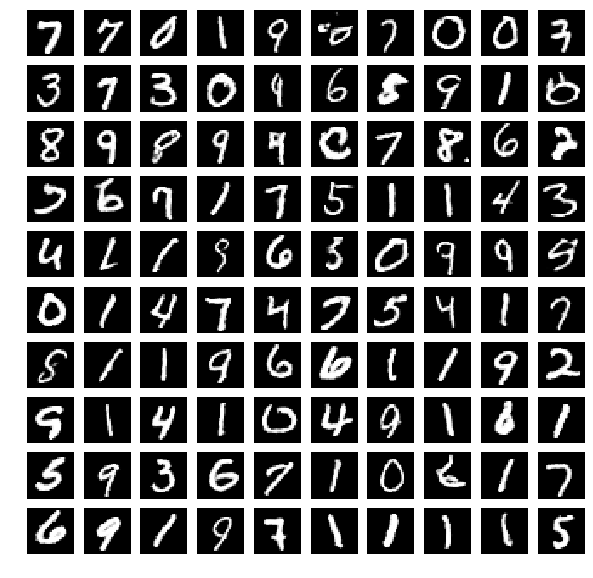

========== Epoch 131 ==========

CGAN loss = 1.7120000123977661	 Discr. loss = 0.421999990940094
========== Epoch 132 ==========

CGAN loss = 1.2970000505447388	 Discr. loss = 0.48899999260902405
========== Epoch 133 ==========

CGAN loss = 1.5770000219345093	 Discr. loss = 0.41100001335144043
========== Epoch 134 ==========

CGAN loss = 1.3539999723434448	 Discr. loss = 0.4880000054836273
========== Epoch 135 ==========

CGAN loss = 1.8669999837875366	 Discr. loss = 0.5080000162124634
========== Epoch 136 ==========

CGAN loss = 1.8630000352859497	 Discr. loss = 0.4269999861717224
========== Epoch 137 ==========

CGAN loss = 1.3880000114440918	 Discr. loss = 0.43799999356269836
========== Epoch 138 ==========

CGAN loss = 1.8279999494552612	 Discr. loss = 0.5080000162124634
========== Epoch 139 ==========

CGAN loss = 1.562000036239624	 Discr. loss = 0.46799999475479126
========== Epoch 140 ==========

CGAN loss = 1.5110000371932983	 Discr. loss = 0.4749999940395355
Images should show

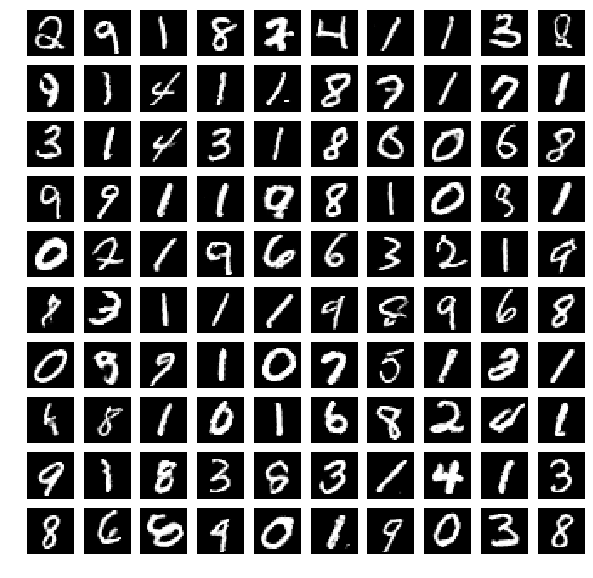

========== Epoch 141 ==========

CGAN loss = 1.7079999446868896	 Discr. loss = 0.4519999921321869
========== Epoch 142 ==========

CGAN loss = 1.3589999675750732	 Discr. loss = 0.5070000290870667
========== Epoch 143 ==========

CGAN loss = 1.9539999961853027	 Discr. loss = 0.44600000977516174
========== Epoch 144 ==========

CGAN loss = 1.6059999465942383	 Discr. loss = 0.4830000102519989
========== Epoch 145 ==========

CGAN loss = 1.7029999494552612	 Discr. loss = 0.43700000643730164
========== Epoch 146 ==========

CGAN loss = 1.7829999923706055	 Discr. loss = 0.492000013589859
========== Epoch 147 ==========

CGAN loss = 1.7289999723434448	 Discr. loss = 0.5099999904632568
========== Epoch 148 ==========

CGAN loss = 1.5410000085830688	 Discr. loss = 0.4699999988079071
========== Epoch 149 ==========

CGAN loss = 1.8639999628067017	 Discr. loss = 0.41600000858306885
========== Epoch 150 ==========

CGAN loss = 1.6790000200271606	 Discr. loss = 0.39500001072883606
Images should sho

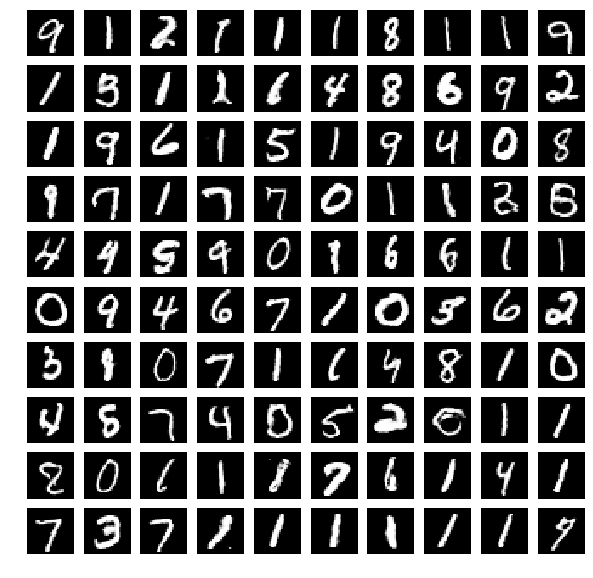

========== Epoch 151 ==========

CGAN loss = 1.5740000009536743	 Discr. loss = 0.48899999260902405
========== Epoch 152 ==========

CGAN loss = 1.7899999618530273	 Discr. loss = 0.5049999952316284
========== Epoch 153 ==========

CGAN loss = 2.013000011444092	 Discr. loss = 0.4129999876022339
========== Epoch 154 ==========

CGAN loss = 1.8769999742507935	 Discr. loss = 0.48100000619888306
========== Epoch 155 ==========

CGAN loss = 1.8660000562667847	 Discr. loss = 0.4699999988079071
========== Epoch 156 ==========

CGAN loss = 1.7680000066757202	 Discr. loss = 0.38499999046325684
========== Epoch 157 ==========

CGAN loss = 1.628000020980835	 Discr. loss = 0.4259999990463257
========== Epoch 158 ==========

CGAN loss = 1.7139999866485596	 Discr. loss = 0.3919999897480011
========== Epoch 159 ==========

CGAN loss = 1.781999945640564	 Discr. loss = 0.38499999046325684
========== Epoch 160 ==========

CGAN loss = 2.117000102996826	 Discr. loss = 0.43799999356269836
Images should show 

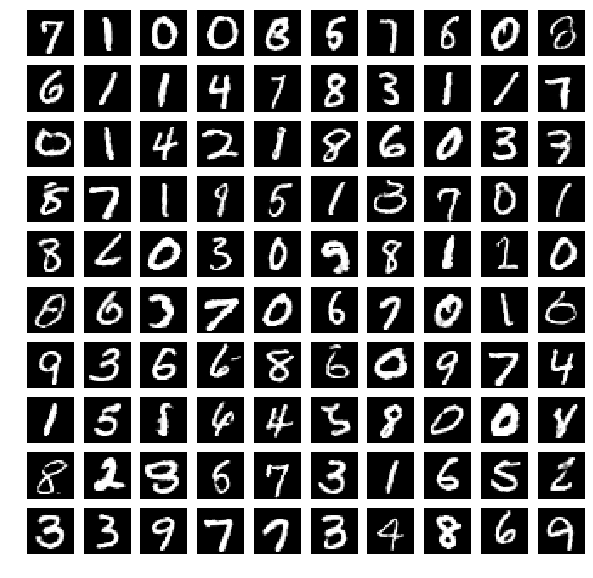

========== Epoch 161 ==========

CGAN loss = 1.7999999523162842	 Discr. loss = 0.4779999852180481
========== Epoch 162 ==========

CGAN loss = 1.75600004196167	 Discr. loss = 0.4180000126361847
========== Epoch 163 ==========

CGAN loss = 1.847000002861023	 Discr. loss = 0.421999990940094
========== Epoch 164 ==========

CGAN loss = 1.6139999628067017	 Discr. loss = 0.5059999823570251
========== Epoch 165 ==========

CGAN loss = 1.7319999933242798	 Discr. loss = 0.42800000309944153
========== Epoch 166 ==========

CGAN loss = 2.2960000038146973	 Discr. loss = 0.40700000524520874
========== Epoch 167 ==========

CGAN loss = 1.8079999685287476	 Discr. loss = 0.3709999918937683
========== Epoch 168 ==========

CGAN loss = 1.784999966621399	 Discr. loss = 0.5
========== Epoch 169 ==========

CGAN loss = 1.475000023841858	 Discr. loss = 0.3869999945163727
========== Epoch 170 ==========

CGAN loss = 1.6390000581741333	 Discr. loss = 0.42100000381469727
Images should show 0


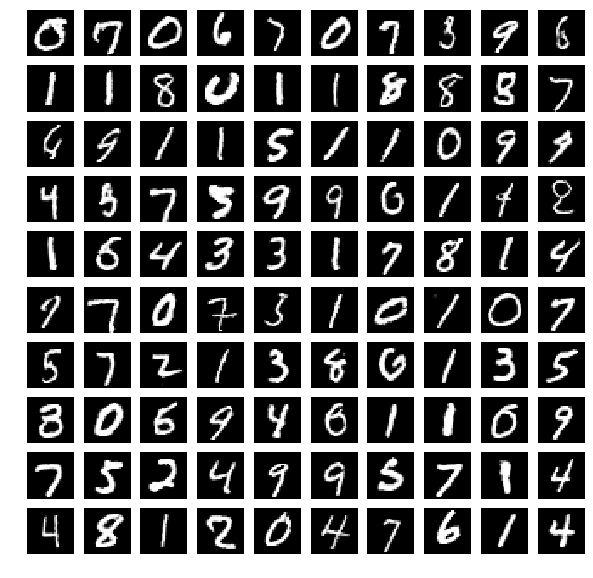

========== Epoch 171 ==========

CGAN loss = 2.2070000171661377	 Discr. loss = 0.38199999928474426
========== Epoch 172 ==========

CGAN loss = 1.6640000343322754	 Discr. loss = 0.4480000138282776
========== Epoch 173 ==========

CGAN loss = 2.0899999141693115	 Discr. loss = 0.3880000114440918
========== Epoch 174 ==========

CGAN loss = 1.7009999752044678	 Discr. loss = 0.48399999737739563
========== Epoch 175 ==========

CGAN loss = 1.7350000143051147	 Discr. loss = 0.4480000138282776
========== Epoch 176 ==========

CGAN loss = 1.8730000257492065	 Discr. loss = 0.3959999978542328
========== Epoch 177 ==========

CGAN loss = 2.186000108718872	 Discr. loss = 0.38100001215934753
========== Epoch 178 ==========

CGAN loss = 2.13100004196167	 Discr. loss = 0.40400001406669617
========== Epoch 179 ==========

CGAN loss = 2.0450000762939453	 Discr. loss = 0.38100001215934753
========== Epoch 180 ==========

CGAN loss = 1.6019999980926514	 Discr. loss = 0.3970000147819519
Images should show

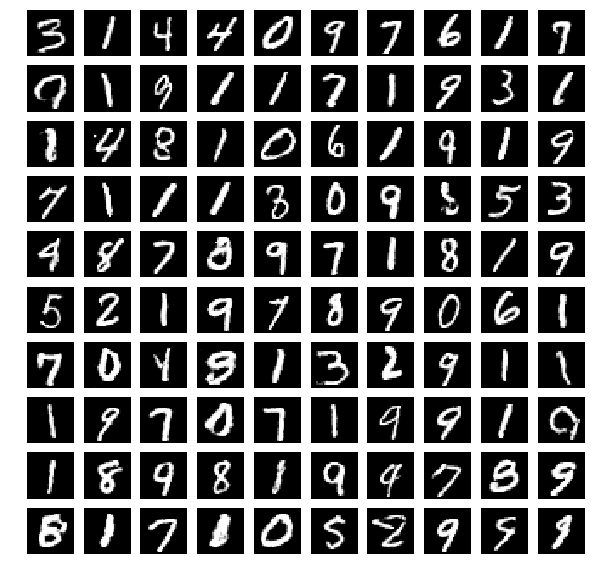

========== Epoch 181 ==========

CGAN loss = 2.3480000495910645	 Discr. loss = 0.39500001072883606
========== Epoch 182 ==========

CGAN loss = 1.5870000123977661	 Discr. loss = 0.515999972820282
========== Epoch 183 ==========

CGAN loss = 2.250999927520752	 Discr. loss = 0.4560000002384186
========== Epoch 184 ==========

CGAN loss = 2.3489999771118164	 Discr. loss = 0.41200000047683716
========== Epoch 185 ==========

CGAN loss = 2.015000104904175	 Discr. loss = 0.414000004529953
========== Epoch 186 ==========

CGAN loss = 1.9819999933242798	 Discr. loss = 0.40299999713897705
========== Epoch 187 ==========

CGAN loss = 1.6510000228881836	 Discr. loss = 0.42800000309944153
========== Epoch 188 ==========

CGAN loss = 1.7359999418258667	 Discr. loss = 0.37400001287460327
========== Epoch 189 ==========

CGAN loss = 1.968999981880188	 Discr. loss = 0.3970000147819519
========== Epoch 190 ==========

CGAN loss = 1.937000036239624	 Discr. loss = 0.3919999897480011
Images should show 8


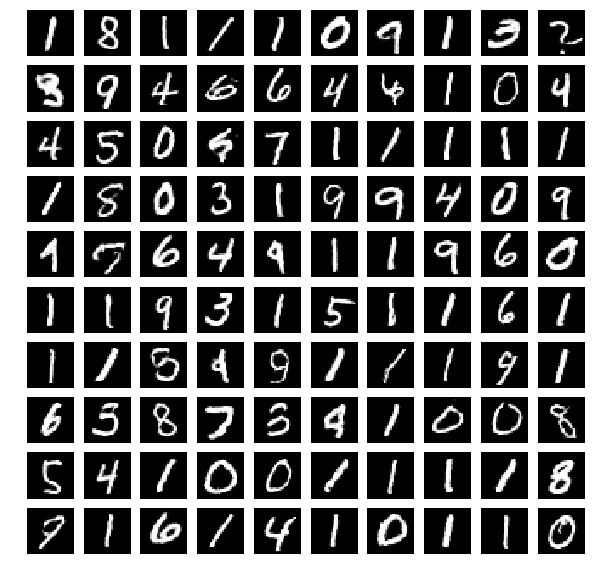

========== Epoch 191 ==========

CGAN loss = 2.2130000591278076	 Discr. loss = 0.39100000262260437
========== Epoch 192 ==========

CGAN loss = 2.006999969482422	 Discr. loss = 0.4269999861717224
========== Epoch 193 ==========

CGAN loss = 2.4860000610351562	 Discr. loss = 0.34599998593330383
========== Epoch 194 ==========

CGAN loss = 1.9550000429153442	 Discr. loss = 0.35499998927116394
========== Epoch 195 ==========

CGAN loss = 1.9819999933242798	 Discr. loss = 0.3790000081062317
========== Epoch 196 ==========

CGAN loss = 1.9759999513626099	 Discr. loss = 0.3580000102519989
========== Epoch 197 ==========

CGAN loss = 1.996000051498413	 Discr. loss = 0.3619999885559082
========== Epoch 198 ==========

CGAN loss = 2.25	 Discr. loss = 0.367000013589859
========== Epoch 199 ==========

CGAN loss = 2.1730000972747803	 Discr. loss = 0.36899998784065247
========== Epoch 200 ==========

CGAN loss = 1.9329999685287476	 Discr. loss = 0.41200000047683716
Images should show 0


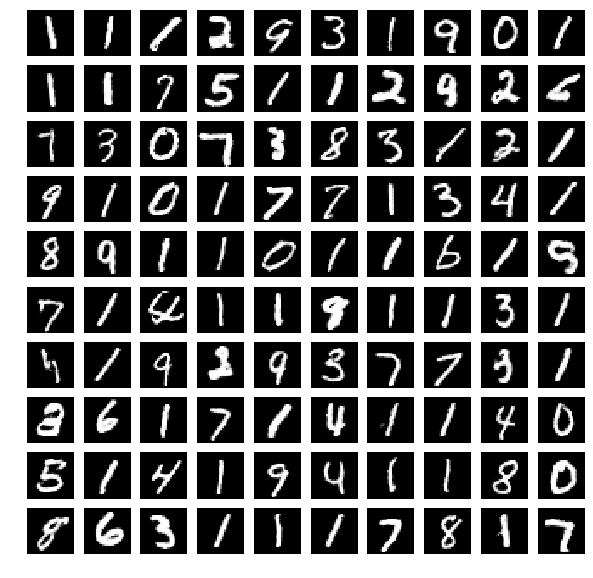

========== Epoch 201 ==========

CGAN loss = 2.1459999084472656	 Discr. loss = 0.41100001335144043
========== Epoch 202 ==========

CGAN loss = 2.509000062942505	 Discr. loss = 0.3479999899864197
========== Epoch 203 ==========

CGAN loss = 1.5839999914169312	 Discr. loss = 0.42399999499320984
========== Epoch 204 ==========

CGAN loss = 1.9229999780654907	 Discr. loss = 0.35600000619888306
========== Epoch 205 ==========

CGAN loss = 2.630000114440918	 Discr. loss = 0.40700000524520874
========== Epoch 206 ==========

CGAN loss = 2.2279999256134033	 Discr. loss = 0.4059999883174896
========== Epoch 207 ==========

CGAN loss = 1.8300000429153442	 Discr. loss = 0.3959999978542328
========== Epoch 208 ==========

CGAN loss = 2.0850000381469727	 Discr. loss = 0.375
========== Epoch 209 ==========

CGAN loss = 1.8179999589920044	 Discr. loss = 0.3930000066757202
========== Epoch 210 ==========

CGAN loss = 1.9570000171661377	 Discr. loss = 0.4129999876022339
Images should show 7


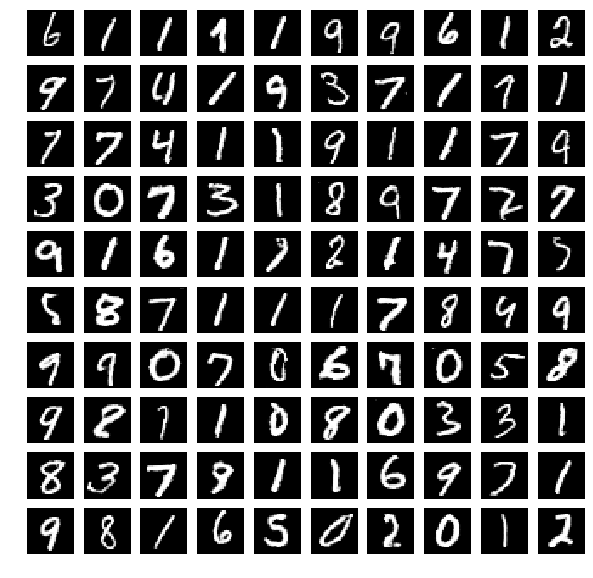

========== Epoch 211 ==========

CGAN loss = 2.2950000762939453	 Discr. loss = 0.32499998807907104
========== Epoch 212 ==========

CGAN loss = 2.5859999656677246	 Discr. loss = 0.41999998688697815
========== Epoch 213 ==========

CGAN loss = 2.0490000247955322	 Discr. loss = 0.4339999854564667
========== Epoch 214 ==========

CGAN loss = 2.2269999980926514	 Discr. loss = 0.3230000138282776
========== Epoch 215 ==========

CGAN loss = 2.260999917984009	 Discr. loss = 0.36000001430511475
========== Epoch 216 ==========

CGAN loss = 1.7910000085830688	 Discr. loss = 0.3529999852180481
========== Epoch 217 ==========

CGAN loss = 2.2690000534057617	 Discr. loss = 0.4050000011920929
========== Epoch 218 ==========

CGAN loss = 2.38100004196167	 Discr. loss = 0.4099999964237213
========== Epoch 219 ==========

CGAN loss = 2.0179998874664307	 Discr. loss = 0.39500001072883606
========== Epoch 220 ==========

CGAN loss = 2.2190001010894775	 Discr. loss = 0.3540000021457672
Images should show 

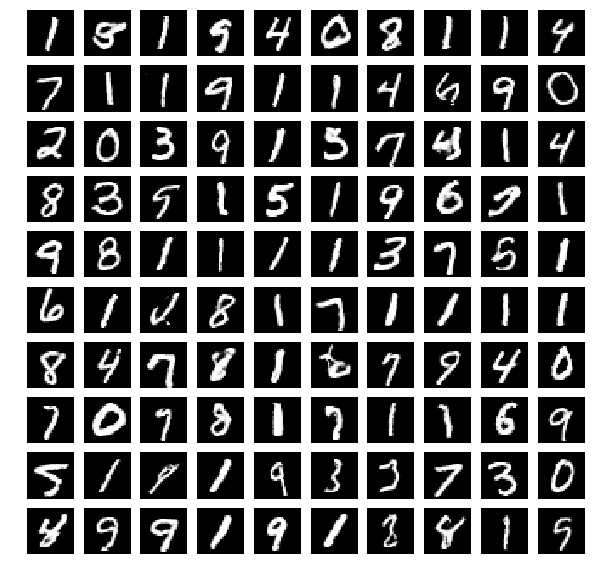

========== Epoch 221 ==========

CGAN loss = 2.11899995803833	 Discr. loss = 0.33500000834465027
========== Epoch 222 ==========

CGAN loss = 2.5829999446868896	 Discr. loss = 0.35600000619888306
========== Epoch 223 ==========

CGAN loss = 2.177999973297119	 Discr. loss = 0.34599998593330383
========== Epoch 224 ==========

CGAN loss = 2.3329999446868896	 Discr. loss = 0.3319999873638153
========== Epoch 225 ==========

CGAN loss = 1.652999997138977	 Discr. loss = 0.3930000066757202
========== Epoch 226 ==========

CGAN loss = 2.246999979019165	 Discr. loss = 0.39399999380111694
========== Epoch 227 ==========

CGAN loss = 2.3610000610351562	 Discr. loss = 0.3970000147819519
========== Epoch 228 ==========

CGAN loss = 1.9149999618530273	 Discr. loss = 0.31700000166893005
========== Epoch 229 ==========

CGAN loss = 2.135999917984009	 Discr. loss = 0.3070000112056732
========== Epoch 230 ==========

CGAN loss = 2.4189999103546143	 Discr. loss = 0.3440000116825104
Images should show 3


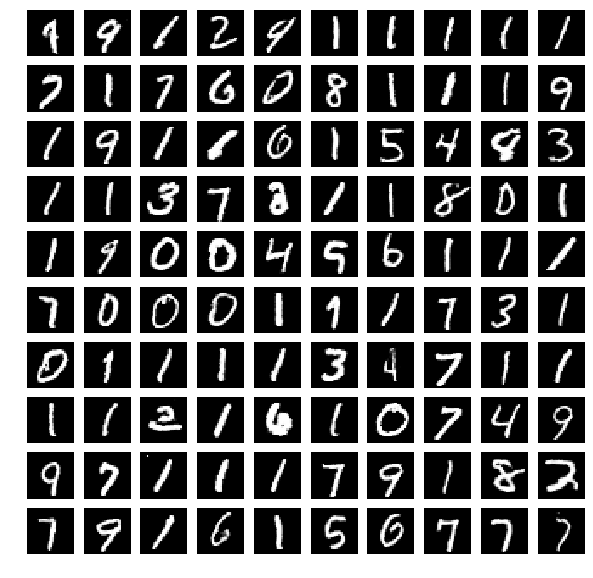

========== Epoch 231 ==========

CGAN loss = 2.5420000553131104	 Discr. loss = 0.43299999833106995
========== Epoch 232 ==========

CGAN loss = 2.5199999809265137	 Discr. loss = 0.30399999022483826
========== Epoch 233 ==========

CGAN loss = 2.693000078201294	 Discr. loss = 0.382999986410141
========== Epoch 234 ==========

CGAN loss = 2.263000011444092	 Discr. loss = 0.36500000953674316
========== Epoch 235 ==========

CGAN loss = 2.4509999752044678	 Discr. loss = 0.3619999885559082
========== Epoch 236 ==========

CGAN loss = 2.4779999256134033	 Discr. loss = 0.328000009059906
========== Epoch 237 ==========

CGAN loss = 2.5989999771118164	 Discr. loss = 0.3019999861717224
========== Epoch 238 ==========

CGAN loss = 2.859999895095825	 Discr. loss = 0.3880000114440918
========== Epoch 239 ==========

CGAN loss = 2.447000026702881	 Discr. loss = 0.3449999988079071
========== Epoch 240 ==========

CGAN loss = 2.365000009536743	 Discr. loss = 0.41999998688697815
Images should show 9


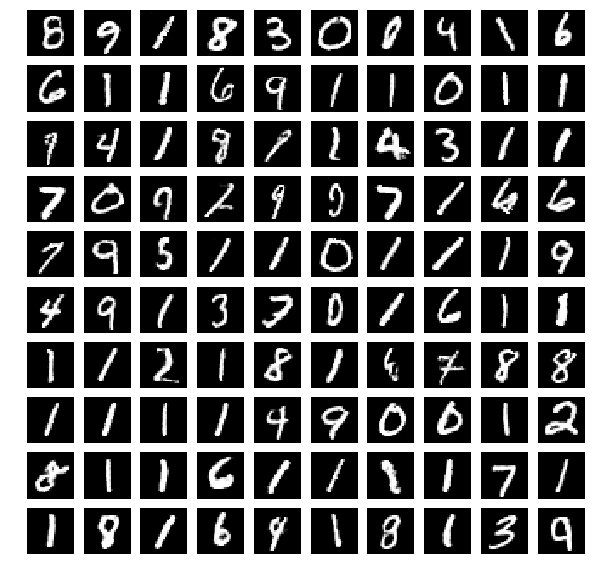

========== Epoch 241 ==========

CGAN loss = 2.571000099182129	 Discr. loss = 0.33799999952316284
========== Epoch 242 ==========

CGAN loss = 2.558000087738037	 Discr. loss = 0.4009999930858612
========== Epoch 243 ==========

CGAN loss = 2.13700008392334	 Discr. loss = 0.39899998903274536
========== Epoch 244 ==========

CGAN loss = 2.38100004196167	 Discr. loss = 0.26899999380111694
========== Epoch 245 ==========

CGAN loss = 2.632999897003174	 Discr. loss = 0.28700000047683716
========== Epoch 246 ==========

CGAN loss = 2.015000104904175	 Discr. loss = 0.36000001430511475
========== Epoch 247 ==========

CGAN loss = 2.4649999141693115	 Discr. loss = 0.31700000166893005
========== Epoch 248 ==========

CGAN loss = 2.808000087738037	 Discr. loss = 0.35499998927116394
========== Epoch 249 ==========

CGAN loss = 1.847000002861023	 Discr. loss = 0.335999995470047
========== Epoch 250 ==========

CGAN loss = 2.697000026702881	 Discr. loss = 0.335999995470047
Images should show 7


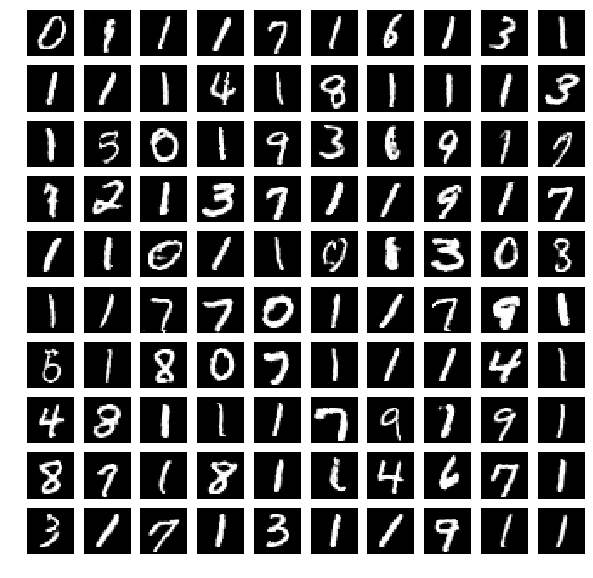

========== Epoch 251 ==========

CGAN loss = 2.4700000286102295	 Discr. loss = 0.3059999942779541
========== Epoch 252 ==========

CGAN loss = 2.2899999618530273	 Discr. loss = 0.30300000309944153
========== Epoch 253 ==========

CGAN loss = 2.6440000534057617	 Discr. loss = 0.29499998688697815
========== Epoch 254 ==========

CGAN loss = 2.4639999866485596	 Discr. loss = 0.3529999852180481
========== Epoch 255 ==========

CGAN loss = 1.9539999961853027	 Discr. loss = 0.36000001430511475
========== Epoch 256 ==========

CGAN loss = 2.5799999237060547	 Discr. loss = 0.4020000100135803
========== Epoch 257 ==========

CGAN loss = 2.2860000133514404	 Discr. loss = 0.30000001192092896
========== Epoch 258 ==========

CGAN loss = 2.937999963760376	 Discr. loss = 0.4189999997615814
========== Epoch 259 ==========

CGAN loss = 2.191999912261963	 Discr. loss = 0.3490000069141388
========== Epoch 260 ==========

CGAN loss = 2.058000087738037	 Discr. loss = 0.3659999966621399
Images should show 

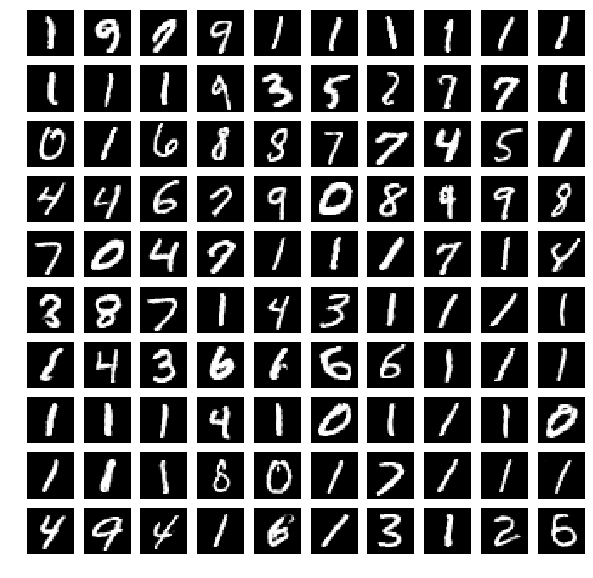

========== Epoch 261 ==========

CGAN loss = 2.0269999504089355	 Discr. loss = 0.36399999260902405
========== Epoch 262 ==========

CGAN loss = 2.3940000534057617	 Discr. loss = 0.3240000009536743
========== Epoch 263 ==========

CGAN loss = 1.7949999570846558	 Discr. loss = 0.35600000619888306
========== Epoch 264 ==========

CGAN loss = 2.384000062942505	 Discr. loss = 0.3269999921321869
========== Epoch 265 ==========

CGAN loss = 2.5429999828338623	 Discr. loss = 0.24500000476837158
========== Epoch 266 ==========

CGAN loss = 2.059999942779541	 Discr. loss = 0.375
========== Epoch 267 ==========

CGAN loss = 1.9859999418258667	 Discr. loss = 0.33500000834465027
========== Epoch 268 ==========

CGAN loss = 2.4809999465942383	 Discr. loss = 0.3869999945163727
========== Epoch 269 ==========

CGAN loss = 2.4179999828338623	 Discr. loss = 0.3160000145435333
========== Epoch 270 ==========

CGAN loss = 2.4019999504089355	 Discr. loss = 0.38499999046325684
Images should show 0


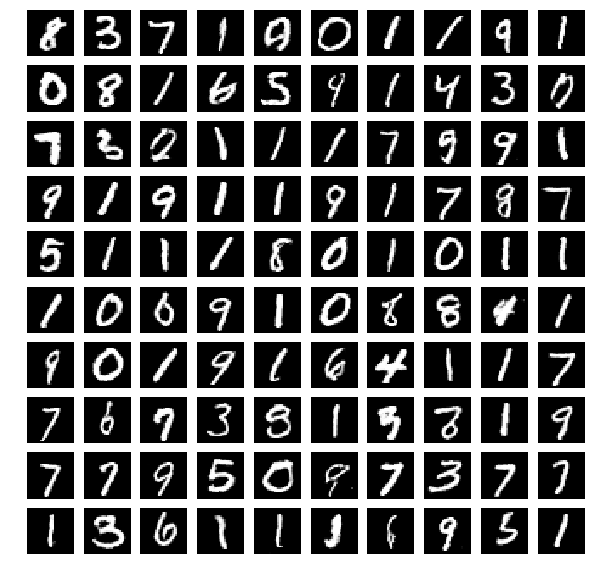

========== Epoch 271 ==========

CGAN loss = 1.809000015258789	 Discr. loss = 0.32899999618530273
========== Epoch 272 ==========

CGAN loss = 2.434999942779541	 Discr. loss = 0.2849999964237213
========== Epoch 273 ==========

CGAN loss = 1.8730000257492065	 Discr. loss = 0.38999998569488525
========== Epoch 274 ==========

CGAN loss = 2.190000057220459	 Discr. loss = 0.44200000166893005
========== Epoch 275 ==========

CGAN loss = 2.7100000381469727	 Discr. loss = 0.24500000476837158
========== Epoch 276 ==========

CGAN loss = 3.0160000324249268	 Discr. loss = 0.3149999976158142
========== Epoch 277 ==========

CGAN loss = 2.6080000400543213	 Discr. loss = 0.29499998688697815
========== Epoch 278 ==========

CGAN loss = 2.4189999103546143	 Discr. loss = 0.3179999887943268
========== Epoch 279 ==========

CGAN loss = 2.2769999504089355	 Discr. loss = 0.3050000071525574
========== Epoch 280 ==========

CGAN loss = 2.115999937057495	 Discr. loss = 0.2370000034570694
Images should show 

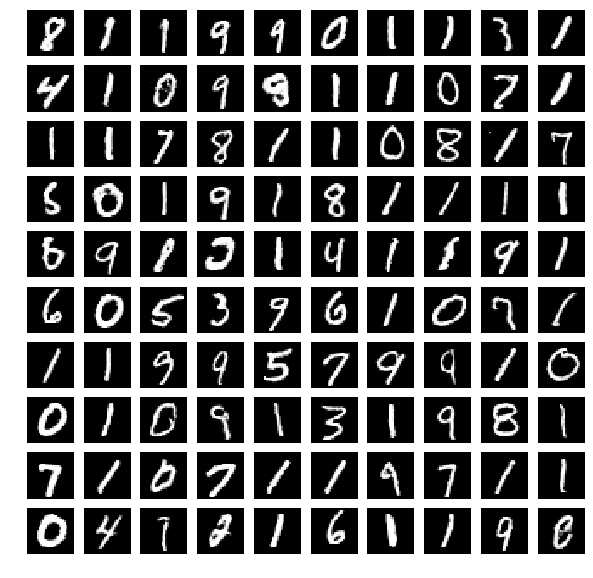

========== Epoch 281 ==========

CGAN loss = 2.7039999961853027	 Discr. loss = 0.28299999237060547
========== Epoch 282 ==========

CGAN loss = 2.996999979019165	 Discr. loss = 0.33799999952316284
========== Epoch 283 ==========

CGAN loss = 2.9649999141693115	 Discr. loss = 0.2809999883174896
========== Epoch 284 ==========

CGAN loss = 2.4049999713897705	 Discr. loss = 0.3540000021457672
========== Epoch 285 ==========

CGAN loss = 2.4240000247955322	 Discr. loss = 0.29100000858306885
========== Epoch 286 ==========

CGAN loss = 3.061000108718872	 Discr. loss = 0.30399999022483826
========== Epoch 287 ==========

CGAN loss = 2.6530001163482666	 Discr. loss = 0.328000009059906
========== Epoch 288 ==========

CGAN loss = 2.4200000762939453	 Discr. loss = 0.3610000014305115
========== Epoch 289 ==========

CGAN loss = 2.499000072479248	 Discr. loss = 0.3330000042915344
========== Epoch 290 ==========

CGAN loss = 2.183000087738037	 Discr. loss = 0.41499999165534973
Images should show 3

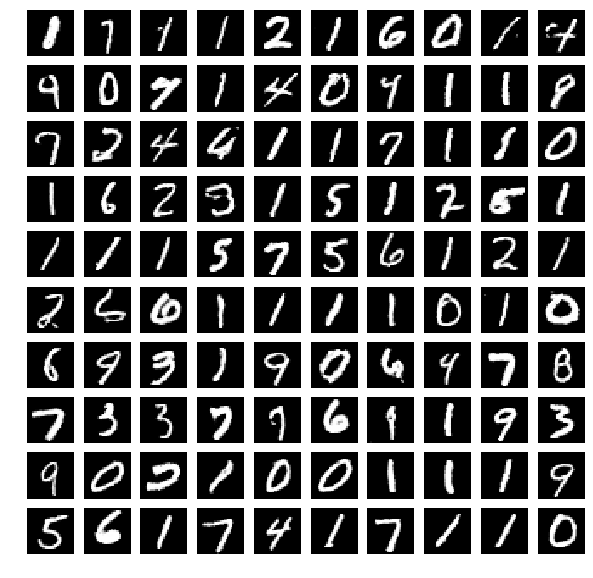

========== Epoch 291 ==========

CGAN loss = 2.6679999828338623	 Discr. loss = 0.3230000138282776
========== Epoch 292 ==========

CGAN loss = 2.6110000610351562	 Discr. loss = 0.26499998569488525
========== Epoch 293 ==========

CGAN loss = 2.937999963760376	 Discr. loss = 0.33799999952316284
========== Epoch 294 ==========

CGAN loss = 2.6630001068115234	 Discr. loss = 0.25999999046325684
========== Epoch 295 ==========

CGAN loss = 2.4260001182556152	 Discr. loss = 0.32600000500679016
========== Epoch 296 ==========

CGAN loss = 3.003000020980835	 Discr. loss = 0.31299999356269836
========== Epoch 297 ==========

CGAN loss = 3.2100000381469727	 Discr. loss = 0.2370000034570694
========== Epoch 298 ==========

CGAN loss = 2.6089999675750732	 Discr. loss = 0.29600000381469727
========== Epoch 299 ==========

CGAN loss = 2.500999927520752	 Discr. loss = 0.3009999990463257
========== Epoch 300 ==========

CGAN loss = 2.674999952316284	 Discr. loss = 0.25099998712539673
Images should sho

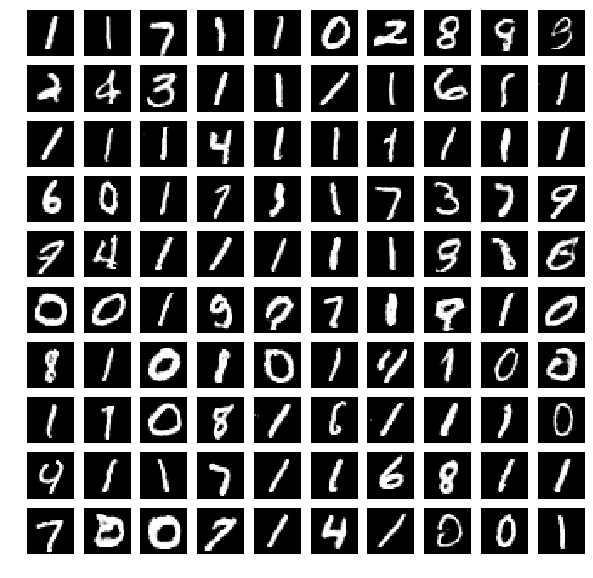

========== Epoch 301 ==========

CGAN loss = 2.8589999675750732	 Discr. loss = 0.3319999873638153
========== Epoch 302 ==========

CGAN loss = 2.118000030517578	 Discr. loss = 0.32100000977516174
========== Epoch 303 ==========

CGAN loss = 2.746999979019165	 Discr. loss = 0.2919999957084656
========== Epoch 304 ==========

CGAN loss = 2.6389999389648438	 Discr. loss = 0.2759999930858612
========== Epoch 305 ==========

CGAN loss = 2.497999906539917	 Discr. loss = 0.28200000524520874
========== Epoch 306 ==========

CGAN loss = 2.6080000400543213	 Discr. loss = 0.30799999833106995
========== Epoch 307 ==========

CGAN loss = 3.3340001106262207	 Discr. loss = 0.38199999928474426
========== Epoch 308 ==========

CGAN loss = 2.6510000228881836	 Discr. loss = 0.25699999928474426
========== Epoch 309 ==========

CGAN loss = 2.8459999561309814	 Discr. loss = 0.32100000977516174
========== Epoch 310 ==========

CGAN loss = 2.753000020980835	 Discr. loss = 0.3529999852180481
Images should show

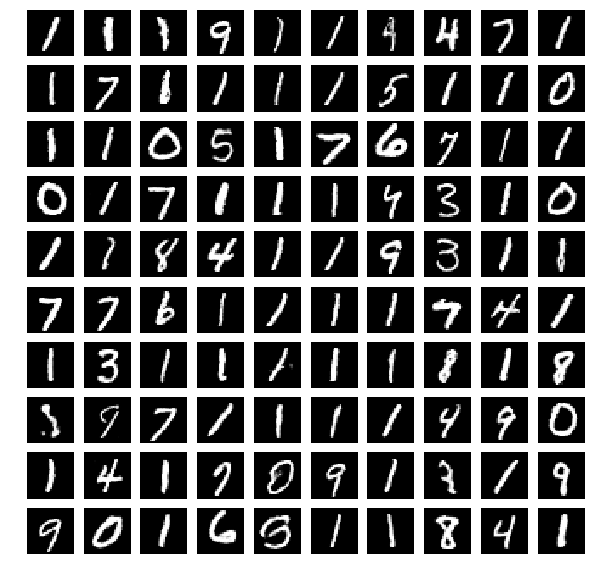

========== Epoch 311 ==========

CGAN loss = 3.1689999103546143	 Discr. loss = 0.28200000524520874
========== Epoch 312 ==========

CGAN loss = 2.3910000324249268	 Discr. loss = 0.24300000071525574
========== Epoch 313 ==========

CGAN loss = 3.1740000247955322	 Discr. loss = 0.3230000138282776
========== Epoch 314 ==========

CGAN loss = 2.9059998989105225	 Discr. loss = 0.28200000524520874
========== Epoch 315 ==========

CGAN loss = 2.4690001010894775	 Discr. loss = 0.3160000145435333
========== Epoch 316 ==========

CGAN loss = 2.2100000381469727	 Discr. loss = 0.27000001072883606
========== Epoch 317 ==========

CGAN loss = 2.696000099182129	 Discr. loss = 0.210999995470047
========== Epoch 318 ==========

CGAN loss = 2.562000036239624	 Discr. loss = 0.33399999141693115
========== Epoch 319 ==========

CGAN loss = 2.492000102996826	 Discr. loss = 0.2930000126361847
========== Epoch 320 ==========

CGAN loss = 2.992000102996826	 Discr. loss = 0.2590000033378601
Images should show 3

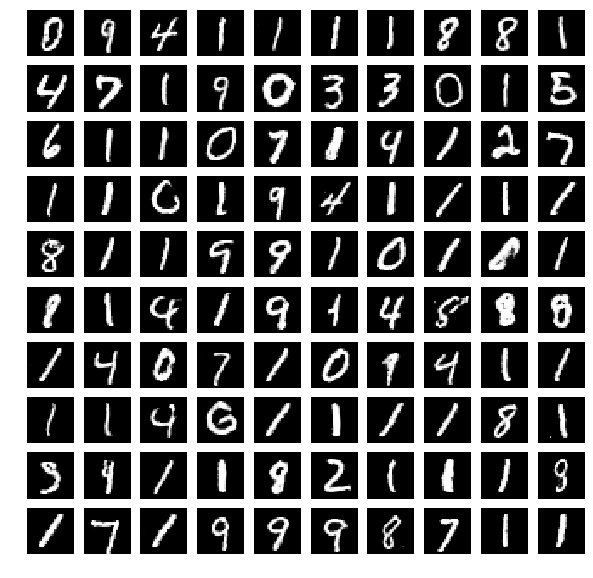

========== Epoch 321 ==========

CGAN loss = 3.315999984741211	 Discr. loss = 0.3790000081062317
========== Epoch 322 ==========

CGAN loss = 2.5420000553131104	 Discr. loss = 0.2840000092983246
========== Epoch 323 ==========

CGAN loss = 2.3550000190734863	 Discr. loss = 0.29600000381469727
========== Epoch 324 ==========

CGAN loss = 2.8389999866485596	 Discr. loss = 0.2800000011920929
========== Epoch 325 ==========

CGAN loss = 2.319000005722046	 Discr. loss = 0.27300000190734863
========== Epoch 326 ==========

CGAN loss = 2.878000020980835	 Discr. loss = 0.257999986410141
========== Epoch 327 ==========

CGAN loss = 2.2699999809265137	 Discr. loss = 0.28299999237060547
========== Epoch 328 ==========

CGAN loss = 2.881999969482422	 Discr. loss = 0.3919999897480011
========== Epoch 329 ==========

CGAN loss = 2.3389999866485596	 Discr. loss = 0.28700000047683716
========== Epoch 330 ==========

CGAN loss = 2.4570000171661377	 Discr. loss = 0.2529999911785126
Images should show 5


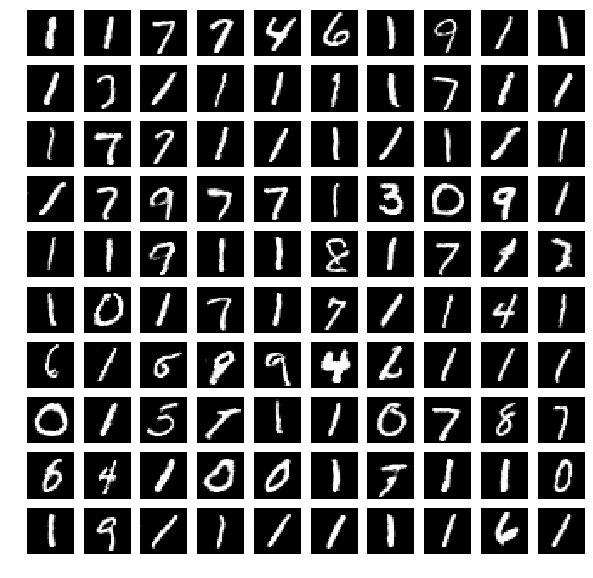

========== Epoch 331 ==========

CGAN loss = 2.7960000038146973	 Discr. loss = 0.25
========== Epoch 332 ==========

CGAN loss = 2.687000036239624	 Discr. loss = 0.2329999953508377
========== Epoch 333 ==========

CGAN loss = 2.4790000915527344	 Discr. loss = 0.2800000011920929
========== Epoch 334 ==========

CGAN loss = 3.4159998893737793	 Discr. loss = 0.3970000147819519
========== Epoch 335 ==========

CGAN loss = 3.0220000743865967	 Discr. loss = 0.289000004529953
========== Epoch 336 ==========

CGAN loss = 2.7669999599456787	 Discr. loss = 0.3100000023841858
========== Epoch 337 ==========

CGAN loss = 2.2839999198913574	 Discr. loss = 0.2919999957084656
========== Epoch 338 ==========

CGAN loss = 3.007999897003174	 Discr. loss = 0.25999999046325684
========== Epoch 339 ==========

CGAN loss = 2.3459999561309814	 Discr. loss = 0.2939999997615814
========== Epoch 340 ==========

CGAN loss = 2.697000026702881	 Discr. loss = 0.2750000059604645
Images should show 2


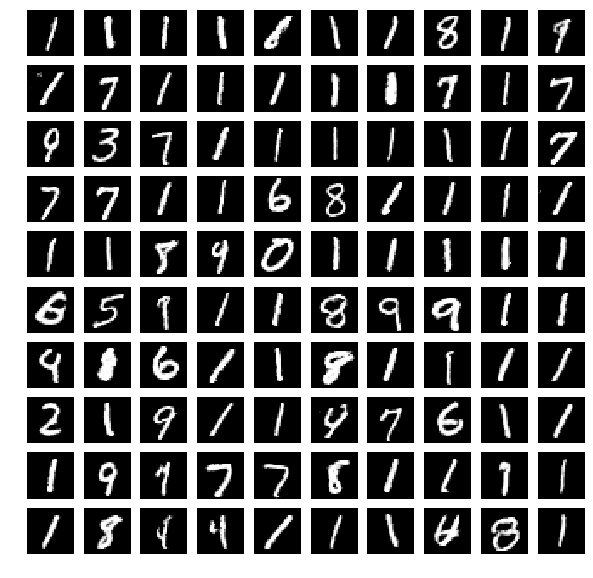

========== Epoch 341 ==========

CGAN loss = 3.259000062942505	 Discr. loss = 0.3700000047683716
========== Epoch 342 ==========

CGAN loss = 2.753999948501587	 Discr. loss = 0.23800000548362732
========== Epoch 343 ==========

CGAN loss = 2.0739998817443848	 Discr. loss = 0.3089999854564667
========== Epoch 344 ==========

CGAN loss = 2.86899995803833	 Discr. loss = 0.2919999957084656
========== Epoch 345 ==========

CGAN loss = 3.319000005722046	 Discr. loss = 0.23399999737739563
========== Epoch 346 ==========

CGAN loss = 2.86299991607666	 Discr. loss = 0.2669999897480011
========== Epoch 347 ==========

CGAN loss = 2.9019999504089355	 Discr. loss = 0.2809999883174896
========== Epoch 348 ==========

CGAN loss = 3.450000047683716	 Discr. loss = 0.2290000021457672
========== Epoch 349 ==========

CGAN loss = 2.700000047683716	 Discr. loss = 0.19200000166893005
========== Epoch 350 ==========

CGAN loss = 2.7699999809265137	 Discr. loss = 0.2540000081062317
Images should show 2


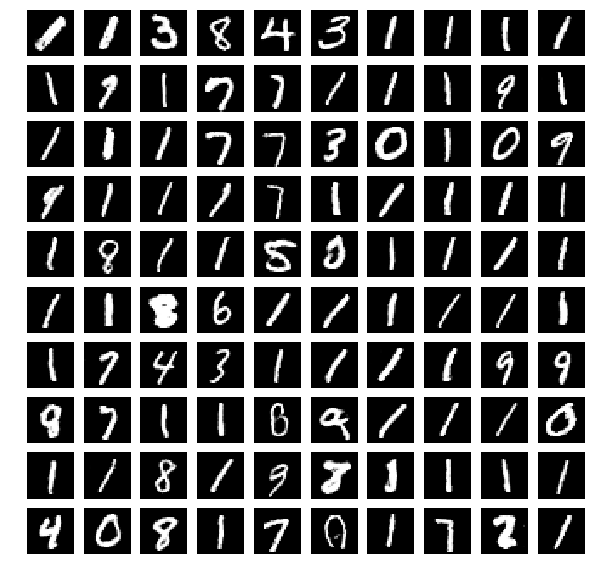

========== Epoch 351 ==========

CGAN loss = 2.75	 Discr. loss = 0.24699999392032623
========== Epoch 352 ==========

CGAN loss = 3.2330000400543213	 Discr. loss = 0.3140000104904175
========== Epoch 353 ==========

CGAN loss = 2.944999933242798	 Discr. loss = 0.2590000033378601
========== Epoch 354 ==========

CGAN loss = 2.6559998989105225	 Discr. loss = 0.29600000381469727
========== Epoch 355 ==========

CGAN loss = 2.2239999771118164	 Discr. loss = 0.2639999985694885
========== Epoch 356 ==========

CGAN loss = 2.7060000896453857	 Discr. loss = 0.26899999380111694
========== Epoch 357 ==========

CGAN loss = 3.0380001068115234	 Discr. loss = 0.21199999749660492
========== Epoch 358 ==========

CGAN loss = 2.490000009536743	 Discr. loss = 0.2409999966621399
========== Epoch 359 ==========

CGAN loss = 3.0810000896453857	 Discr. loss = 0.20800000429153442
========== Epoch 360 ==========

CGAN loss = 2.875999927520752	 Discr. loss = 0.23399999737739563
Images should show 2


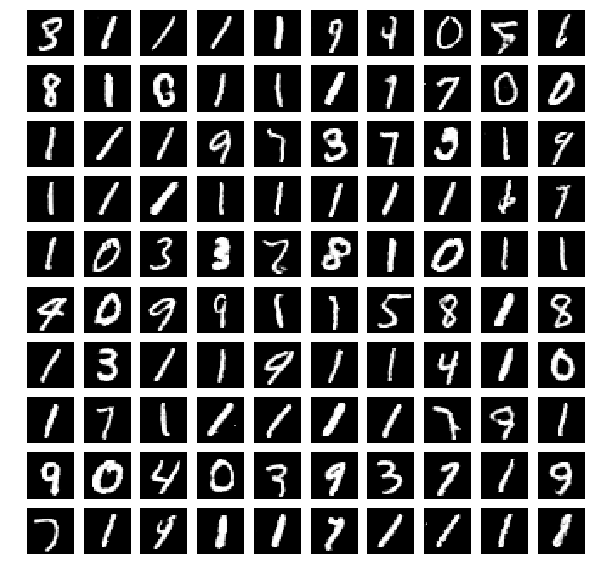

========== Epoch 361 ==========

CGAN loss = 2.5510001182556152	 Discr. loss = 0.33399999141693115
========== Epoch 362 ==========

CGAN loss = 2.4790000915527344	 Discr. loss = 0.3569999933242798
========== Epoch 363 ==========

CGAN loss = 3.125999927520752	 Discr. loss = 0.3580000102519989
========== Epoch 364 ==========

CGAN loss = 2.947999954223633	 Discr. loss = 0.21199999749660492
========== Epoch 365 ==========

CGAN loss = 2.431999921798706	 Discr. loss = 0.25
========== Epoch 366 ==========

CGAN loss = 2.753999948501587	 Discr. loss = 0.2619999945163727
========== Epoch 367 ==========

CGAN loss = 2.940000057220459	 Discr. loss = 0.23100000619888306
========== Epoch 368 ==========

CGAN loss = 2.438999891281128	 Discr. loss = 0.23000000417232513
========== Epoch 369 ==========

CGAN loss = 2.628000020980835	 Discr. loss = 0.2669999897480011
========== Epoch 370 ==========

CGAN loss = 2.9690001010894775	 Discr. loss = 0.3779999911785126
Images should show 9


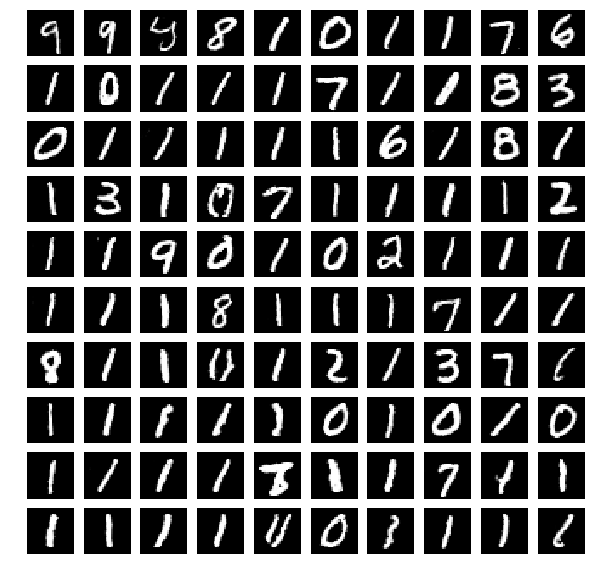

========== Epoch 371 ==========

CGAN loss = 2.4570000171661377	 Discr. loss = 0.22699999809265137
========== Epoch 372 ==========

CGAN loss = 2.4609999656677246	 Discr. loss = 0.2280000001192093
========== Epoch 373 ==========

CGAN loss = 3.6410000324249268	 Discr. loss = 0.22699999809265137
========== Epoch 374 ==========

CGAN loss = 3.622999906539917	 Discr. loss = 0.20399999618530273
========== Epoch 375 ==========

CGAN loss = 3.190000057220459	 Discr. loss = 0.2409999966621399
========== Epoch 376 ==========

CGAN loss = 2.9600000381469727	 Discr. loss = 0.33399999141693115
========== Epoch 377 ==========

CGAN loss = 3.49399995803833	 Discr. loss = 0.25999999046325684
========== Epoch 378 ==========



In [0]:

d_losses = []
d_accs = []
g_losses = []
g_accs = []

epochs = 20000
batch_size = 128

#X_train = (train_set_images.reshape(60000, 1, 28, 28).astype(np.float32) - 0.5)/0.5
X_train = train_set_images
batch_count = int(X_train.shape[0] / batch_size)

for e in range(epochs):
  print(10*"="+" Epoch {} ".format(e)+10*"="+"\n")
  for _ in range(batch_count):
    # Get a random set of fake noise and labels
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
    noise_labels = to_categorical(np.random.randint(0, 10, batch_size), num_classes=10)

    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
    label_batch = train_set_labels[np.random.randint(0, train_set_labels.shape[0], size=batch_size)]

    # Generate some fake MNIST images using the generator
    fake_images = gen.predict([noise, noise_labels])

    # Concatenate the fake and real images + labels
    X = np.concatenate([image_batch, fake_images])
    labels = np.concatenate([label_batch, noise_labels])

    # Labels for generated and real data
    y_dis = np.zeros(2*batch_size)
    # Set reference to 1 for real samples
    y_dis[:batch_size] = 1

    # Train discriminator with this batch of samples
    dis.trainable = True
    d_loss, d_acc = dis.train_on_batch([X, labels], y_dis)
    #print("Discriminator loss = {}, accuracy = {}".format(d_loss, d_acc))

    # Train generator with a new batch of generated samples & labels
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
    noise_labels = to_categorical(np.random.randint(0, 10, batch_size), num_classes=10)

    # From the generator's perspective, the discriminator should predict
    # ones for all samples
    y_gen = np.ones(batch_size)

    # Freeze the discriminator part
    dis.trainable = False

    # Train the GAN to predict ones
    g_loss, g_acc = gan.train_on_batch([noise, noise_labels], y_gen)
    #print("CGAN loss = {}, accuracy = {}".format(g_loss, g_acc))

    # Store loss of most recent batch from this epoch
  print("CGAN loss = {}\t Discr. loss = {}".format(round(g_loss, 3), round(d_loss, 3)))
  d_losses.append(d_loss)
  d_accs.append(d_acc)
  g_losses.append(g_loss)
  g_accs.append(g_acc)
  if e % 10 == 0:
    noise = np.random.uniform(-1.0, 1.0, size=[100, latent_dim])

    show = np.random.randint(0, 10)
    print("Images should show {}".format(show))

    noise_labels = to_categorical(np.repeat(show, 100), num_classes=10)
    im = gen.predict([noise, noise_labels])
    im = im.reshape(100, 28, 28)

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(100):
      axes[i].imshow(im[i, :, :], cmap='gray')
      axes[i].axis('off')
    plt.show()
    gen.save("gen_epoch{}.h5".format(e))

The generator trains quickly to a state where it can generate high fidelity numbers. However, it takes a high amount of epochs to reach the state where it correctly generates the numbers given to it as label input. After running for several hours, the training was stopped, showing a little more correctly generated samples than at the beginning. Also, the variability in generated numbers is slowly dropping when progressing through the epochs, but a state where all generated numbers are the same as the given label is not reached. A lot more epochs are necessary to get a generator that better incorporates the label input.

# Pretrained models

You can download some pre-trained generator models for the GAN training exercises from [this link](https://filesender.surf.nl/?s=download&token=475362bb-4098-4376-979b-b0d3ae9e3dd0), but of course it's much more interesting to train them yourself. Use 


```
generator = keras.models.load_model(filename)
```

to load the model.
